# Unemployment in the US During a Pandemic: 
## LSTM Model of COVID-19 \& Twitter Sentiment Data to Predict Unemployment
### Exam Numbers: 12, 21 & 161

## Necessary imports and installations

In order to run this notebook, you will first need to execute the 3 following cells. Some packages need to be installed before the import statements work so please consider the pip install statements if you get an error. The next cell contains the connector function that we were given in the lectures.

In [1]:
# Define the connector class (copied from lecture material)

def ratelimit():
    "A function that handles the rate of your calls."
    time.sleep(0.5) # sleep one second.

class Connector():
  def __init__(self,logfile,overwrite_log=False,connector_type='requests',session=False,path2selenium='',n_tries = 5,timeout=30):
    """This Class implements a method for reliable connection to the internet and monitoring. 
    It handles simple errors due to connection problems, and logs a range of information for basic quality assessments
    
    Keyword arguments:
    logfile -- path to the logfile
    overwrite_log -- bool, defining if logfile should be cleared (rarely the case). 
    connector_type -- use the 'requests' module or the 'selenium'. Will have different since the selenium webdriver does not have a similar response object when using the get method, and monitoring the behavior cannot be automated in the same way.
    session -- requests.session object. For defining custom headers and proxies.
    path2selenium -- str, sets the path to the geckodriver needed when using selenium.
    n_tries -- int, defines the number of retries the *get* method will try to avoid random connection errors.
    timeout -- int, seconds the get request will wait for the server to respond, again to avoid connection errors.
    """
    
    ## Initialization function defining parameters. 
    self.n_tries = n_tries # For avoiding triviel error e.g. connection errors, this defines how many times it will retry.
    self.timeout = timeout # Defining the maximum time to wait for a server to response.
    ## not implemented here, if you use selenium.
    if connector_type=='selenium':
      assert path2selenium!='', "You need to specify the path to you geckodriver if you want to use Selenium"
      from selenium import webdriver 
      ## HIN download the latest geckodriver here: https://github.com/mozilla/geckodriver/releases

      assert os.path.isfile(path2selenium),'You need to insert a valid path2selenium the path to your geckodriver. You can download the latest geckodriver here: https://github.com/mozilla/geckodriver/releases'
      self.browser = webdriver.Chrome(executable_path=path2selenium) # start the browser with a path to the geckodriver.

    self.connector_type = connector_type # set the connector_type
    
    if session: # set the custom session
      self.session = session
    else:
      self.session = requests.session()
    self.logfilename = logfile # set the logfile path
    ## define header for the logfile
    header = ['id','project','connector_type','t', 'delta_t', 'url', 'redirect_url','response_size', 'response_code','success','error']
    if os.path.isfile(logfile):        
      if overwrite_log==True:
        self.log = open(logfile,'w')
        self.log.write(';'.join(header))
      else:
        self.log = open(logfile,'a')
    else:
      self.log = open(logfile,'w')
      self.log.write(';'.join(header))
    ## load log 
    with open(logfile,'r') as f: # open file
        
      l = f.read().split('\n') # read and split file by newlines.
      ## set id
      if len(l)<=1:
        self.id = 0
      else:
        self.id = int(l[-1][0])+1
            
  def get(self,url,project_name):
    """Method for connector reliably to the internet, with multiple tries and simple error handling, as well as default logging function.
    Input url and the project name for the log (i.e. is it part of mapping the domain, or is it the part of the final stage in the data collection).
    
    Keyword arguments:
    url -- str, url
    project_name -- str, Name used for analyzing the log. Use case could be the 'Mapping of domain','Meta_data_collection','main data collection'. 
    """
     
    project_name = project_name.replace(';','-') # make sure the default csv seperator is not in the project_name.
    if self.connector_type=='requests': # Determine connector method.
      for _ in range(self.n_tries): # for loop defining number of retries with the requests method.
        ratelimit()
        t = time.time()
        try: # error handling 
          response = self.session.get(url,timeout = self.timeout) # make get call

          err = '' # define python error variable as empty assumming success.
          success = True # define success variable
          redirect_url = response.url # log current url, after potential redirects 
          dt = t - time.time() # define delta-time waiting for the server and downloading content.
          size = len(response.text) # define variable for size of html content of the response.
          response_code = response.status_code # log status code.
          ## log...
          call_id = self.id # get current unique identifier for the call
          self.id+=1 # increment call id
          #['id','project_name','connector_type','t', 'delta_t', 'url', 'redirect_url','response_size', 'response_code','success','error']
          row = [call_id,project_name,self.connector_type,t,dt,url,redirect_url,size,response_code,success,err] # define row to be written in the log.
          self.log.write('\n'+';'.join(map(str,row))) # write log.
          self.log.flush()
          return response,call_id # return response and unique identifier.

        except Exception as e: # define error condition
          err = str(e) # python error
          response_code = '' # blank response code 
          success = False # call success = False
          size = 0 # content is empty.
          redirect_url = '' # redirect url empty 
          dt = t - time.time() # define delta t

          ## log...
          call_id = self.id # define unique identifier
          self.id+=1 # increment call_id

          row = [call_id,project_name,self.connector_type,t,dt,url,redirect_url,size,response_code,success,err] # define row
          self.log.write('\n'+';'.join(map(str,row))) # write row to log.
          self.log.flush()
    else:
      t = time.time()
      ratelimit()
      self.browser.get(url) # use selenium get method
      ## log
      call_id = self.id # define unique identifier for the call. 
      self.id+=1 # increment the call_id
      err = '' # blank error message
      success = '' # success blank
      redirect_url = self.browser.current_url # redirect url.
      dt = t - time.time() # get time for get method ... NOTE: not necessarily the complete load time.
      size = len(self.browser.page_source) # get size of content ... NOTE: not necessarily correct, since selenium works in the background, and could still be loading.
      response_code = '' # empty response code.
      row = [call_id,project_name,self.connector_type,t,dt,url,redirect_url,size,response_code,success,err] # define row 
      self.log.write('\n'+';'.join(map(str,row))) # write row to log file.
      self.log.flush()
    # Using selenium it will not return a response object, instead you should call the browser object of the connector.
    ## connector.browser.page_source will give you the html.
      return None,call_id

In [2]:
#!pip install pyjsparser
#!pip install js2xml
#!pip install GetOldTweets3
#!pip install textblob
#!pip install wordcloud
#!pip install pyjsparser
#!pip install js2xml
#!pip install ratelimit
#!pip install matplotlib_venn
#!pip install geopandas
#conda install -c plotly plotly-orca

#Note that it might also be necessary to install keras and tensorflow to your device if you have not installed them before

import scipy as sp
from math import isnan
#import pydst
#import geopandas as gdp
#from matplotlib_venn import venn2
from bokeh.layouts import column, row, widgetbox
from bokeh.models import CustomJS, Slider, Toggle
import tqdm
import requests,os,time
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
import seaborn as sns 
import re
from bs4 import BeautifulSoup
import selenium
import time
from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.common.keys import Keys
from datetime import datetime, timedelta
import GetOldTweets3 as got
import pyjsparser
import js2xml
from textblob import TextBlob
import json
import pylab
from ratelimit import limits, sleep_and_retry
import plotly.graph_objects as go
from plotly.subplots import make_subplots
%matplotlib inline 
import scraping_class
logfile = 'log_exam_project.csv' ## name your log file.
connector = Connector(logfile)
pd.options.mode.chained_assignment = None

In [3]:
session = requests.session()
session.headers['email'] = 'gfp257@alumni.ku.dk' 
session.headers['name'] = 'Jacob Hein'
session.headers['reason']= 'University of Copenhagen summerschool students obtaining data for data science exam project, data will not be published or monetized'
session.headers

{'User-Agent': 'python-requests/2.22.0', 'Accept-Encoding': 'gzip, deflate', 'Accept': '*/*', 'Connection': 'keep-alive', 'email': 'gfp257@alumni.ku.dk', 'name': 'Jacob Hein', 'reason': 'University of Copenhagen summerschool students obtaining data for data science exam project, data will not be published or monetized'}

In [ ]:
# The following part of the notebook runs the machine learning part of the project
# which includes training, validation and testing of the LSTM neural network.
# There, these these imports require Keras & Tensorflow to be installed
# or else the notebook could be run in Google Colab to avoid installation of the following: 
import scipy.stats
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import GRU
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras import regularizers
from keras import optimizers
from keras import initializers
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from math import sqrt
from pandas import read_csv
from pandas import DataFrame
from pandas import concat

# 1. Scrape information about US states and Governor names

In [4]:
#Select url and apply beautiful soup to get website data

url = 'https://ballotpedia.org/List_of_governors_of_the_American_states'
response,call_id = connector.get(url,'governors')
soup = BeautifulSoup(response.text,'lxml')
soup.prettify()
#Select only the table on the page, and then only the table data
My_table = soup.find('table')
information = My_table.findAll('td')

#Create empty list for variables, select only the text from the list, and append all the text to a list
allvariables=[]
for variable in information: 
   individualtitle = variable.get_text() 
   allvariables.append(individualtitle) 

#Split the list by desired variables
govstate=allvariables[::4]
full_name=allvariables[1::4]
party=allvariables[2::4]

#Create variable with only the last name, such that all last names are in the same format
newname_1=list.copy(full_name)
nomiddlename =[i.split(' ', 1)[-1] for i in newname_1]
nosecondmiddlename =[i.split(' ', 1)[-1] for i in nomiddlename]
lastname=[i.split(' ', 1)[0] for i in nosecondmiddlename]

#Create a new variale with both title and last name of governors
title= []
for k in lastname:
    combined= 'Governor ' + k
    title.append(combined)

#Create a new variable with abbreviated title and lastname
abbrtitle= []
for k in lastname:
    combined= 'Gov. ' + k
    abbrtitle.append(combined)

#Create state variable
states=list.copy(govstate)
state =[i.split(' ', 2)[-1] for i in states]

#Zip all the lists
gov_df = pd.DataFrame(list(zip(state, govstate, full_name,title, abbrtitle, party)), 
                      columns=['State', 'FullTitle', 'Name','MediumTitle','TinyTitle','Party'])

#Create a list of states from state column
#states = 

#Print resulting df
gov_df.head()

State              FullTitle           Name        MediumTitle  \
0    Georgia    Governor of Georgia     Brian Kemp      Governor Kemp   
1  Tennessee  Governor of Tennessee       Bill Lee       Governor Lee   
2   Missouri   Governor of Missouri    Mike Parson    Governor Parson   
3     Kansas     Governor of Kansas    Laura Kelly     Governor Kelly   
4     Alaska     Governor of Alaska  Mike Dunleavy  Governor Dunleavy   

       TinyTitle        Party  
0      Gov. Kemp  Republican   
1       Gov. Lee  Republican   
2    Gov. Parson  Republican   
3     Gov. Kelly  Democratic   
4  Gov. Dunleavy  Republican

In [5]:
#Print log-file 
pd.read_csv(logfile,sep=';')

id    project connector_type             t  delta_t  \
0   0  governors       requests  1.598615e+09 -0.79211   

                                                 url  \
0  https://ballotpedia.org/List_of_governors_of_t...   

                                        redirect_url  response_size  \
0  https://ballotpedia.org/List_of_governors_of_t...          88038   

   response_code  success  error  
0            200     True    NaN

## Select only top 10 US states

In [6]:
territories_we_dont_want = ['American Samoa', 'Puerto Rico', 'the U.S. Virgin Islands', 'the Northern Mariana Islands', 'Guam']
#gov_df[gov_df.State != 'American Samoa']
gov_df = gov_df[~gov_df['State'].isin(territories_we_dont_want)].sort_values('State').reset_index().drop('index', axis=1)
ten_biggest_states = ["California", "Texas", "Florida", "New York", "Illinois", "Pennsylvania", "Ohio", "Georgia", "North Carolina", "Michigan"]
gov_df_10_big =  gov_df[gov_df['State'].isin(ten_biggest_states)].sort_values('State').reset_index().drop('index', axis=1)
gov_df_10_big

State                   FullTitle                    Name  \
0      California      Governor of California            Gavin Newsom   
1         Florida         Governor of Florida            Ron DeSantis   
2         Georgia         Governor of Georgia              Brian Kemp   
3        Illinois        Governor of Illinois           J.B. Pritzker   
4        Michigan        Governor of Michigan        Gretchen Whitmer   
5        New York        Governor of New York            Andrew Cuomo   
6  North Carolina  Governor of North Carolina              Roy Cooper   
7            Ohio            Governor of Ohio  Richard Michael DeWine   
8    Pennsylvania    Governor of Pennsylvania                Tom Wolf   
9           Texas           Governor of Texas             Greg Abbott   

         MediumTitle      TinyTitle        Party  
0    Governor Newsom    Gov. Newsom  Democratic   
1  Governor DeSantis  Gov. DeSantis  Republican   
2      Governor Kemp      Gov. Kemp  Republican   
3  Governor Pritzker  Gov. Pritzker  Democratic   
4   Governor Whitmer   Gov. Whitmer  Democratic   
5     Governor Cuomo     Gov. Cuomo  Democratic   
6    Governor Cooper    Gov. Cooper  Democratic   
7    Governor DeWine    Gov. DeWine  Republican   
8      Governor Wolf      Gov. Wolf  Democratic   
9    Governor Abbott    Gov. Abbott  Republican

# 2.Scrape twitter handles for selected news sites

In [7]:
#Select url and apply beautiful soup to get website data
url = 'https://memeburn.com/2010/09/the-100-most-influential-news-media-twitter-accounts/' 
response,call_id = connector.get(url,'twitter_handles')
souptwitter = BeautifulSoup(response.text, "html.parser")
souptwitter.prettify()

#Select only the table on the page, and then only the table data
table = souptwitter.find('table')
twitterlinks = table.findAll('a')

#getting the twitter handles
fullhandle=[]
for variable in twitterlinks: 
   individualtitle = variable.get_text() 
   fullhandle.append(individualtitle) 

#splitting from @, which is not not needed for our purposes
handle =[i.split('@', 1)[-1] for i in fullhandle]

print('Number of news agencies: ',len(handle))
#print the first 5 elements of the list
handle[0:5]

Number of news agencies:  100


['mashable', 'cnnbrk', 'big_picture', 'theonion', 'time']

In [8]:
#Again print logile 
pd.read_csv(logfile,sep=';')

id          project connector_type             t   delta_t  \
0   0        governors       requests  1.598615e+09 -0.792110   
1   1  twitter_handles       requests  1.598615e+09 -0.410281   

                                                 url  \
0  https://ballotpedia.org/List_of_governors_of_t...   
1  https://memeburn.com/2010/09/the-100-most-infl...   

                                        redirect_url  response_size  \
0  https://ballotpedia.org/List_of_governors_of_t...          88038   
1  https://memeburn.com/2010/09/the-100-most-infl...         123079   

   response_code  success  error  
0            200     True    NaN  
1            200     True    NaN

# 3. Scrape unemployment data from US Gov

In [9]:
url = 'https://oui.doleta.gov/unemploy/claims.asp'
def fetch_unemployment_rate_by_state(url):
    '''
    This function calls the site of the US Department of Labor using the Connector() with the 'selenium' type,
    to scrape the weekly unemployment rates for each state in 2020.
    '''
    connector=Connector(logfile, connector_type='selenium', path2selenium=r'C:\Users\jacob\OneDrive\Skrivebord\chromedriver.exe', session=session.headers )
    browser=connector.browser
    connector.get(url, 'unemployment')

    # clicking states radio button
    browser.find_element_by_css_selector("input[type='radio'][value='state']").click()
    browser.find_element_by_xpath("//select[@name='strtdate']/option[text()='2020']").click()
    
    # obtaining all state names
    response = requests.get(url)
    html = response.text
    soup = BeautifulSoup(html,'lxml')
    table = soup.find('select',{'id':'states'})
    states = table.get_text().split('\n')[1:-1]
    territory = ['Virgin Islands','Puerto Rico', 'District of Columbia']
    states = [state for state in states if state not in territory]
    
    # clicking all states
    for i in states:
        xpath = f"//select[@name='states[]']/option[text()='{i}']"
        browser.find_element_by_xpath(xpath).click()
    
    # click submit
    browser.find_element_by_css_selector("input[type='submit'][value='Submit']").click()
    
    df = pd.read_html(browser.page_source, header=1)[0]
    browser.quit()
    return df

unemp_df = fetch_unemployment_rate_by_state(url)
unemp_df_copy = unemp_df.copy()
unemp_df_copy['indices'] = pd.to_datetime(unemp_df_copy['Filed week ended']).dt.strftime('%Y-%m-%d')
unemp_df_copy.set_index('indices', inplace=True)
unemp_df_copy.index.name = None 
unemp_df = unemp_df_copy[['State', 'Insured Unemployment Rate']]
unemp_df

State  Insured Unemployment Rate
2020-01-04  Alabama                       0.96
2020-01-11  Alabama                       1.10
2020-01-18  Alabama                       0.90
2020-01-25  Alabama                       0.96
2020-02-01  Alabama                       0.90
...             ...                        ...
2020-07-18  Wyoming                       5.01
2020-07-25  Wyoming                       4.83
2020-08-01  Wyoming                       4.77
2020-08-08  Wyoming                       4.20
2020-08-15  Wyoming                       3.92

[1650 rows x 2 columns]

In [10]:
#Again print logile 
pd.read_csv(logfile,sep=';')

id          project connector_type             t   delta_t  \
0   0        governors       requests  1.598615e+09 -0.792110   
1   1  twitter_handles       requests  1.598615e+09 -0.410281   
2   2     unemployment       selenium  1.598615e+09 -2.395369   

                                                 url  \
0  https://ballotpedia.org/List_of_governors_of_t...   
1  https://memeburn.com/2010/09/the-100-most-infl...   
2         https://oui.doleta.gov/unemploy/claims.asp   

                                        redirect_url  response_size  \
0  https://ballotpedia.org/List_of_governors_of_t...          88038   
1  https://memeburn.com/2010/09/the-100-most-infl...         123079   
2         https://oui.doleta.gov/unemploy/claims.asp          14381   

   response_code success  error  
0          200.0    True    NaN  
1          200.0    True    NaN  
2            NaN     NaN    NaN

# 4. Scrape Worldometers Coronovirus data

In [11]:
def COVID_call(state):
    '''This function constructs the corresponding worldometers URL and 
    then requests the COVID Data for that state for a period from calendar week 1 in 2020 up  until the current date. 
    The resulting data is put into a dateset with a time index.
    
    Input: US state
    
    Output: Data frame Daily New Cases and Daily New Deaths
    '''
    
    url = 'https://www.worldometers.info/coronavirus/usa/' + state + '/'
    response,call_id = connector.get(url,'Covid19_call')
    soup = BeautifulSoup(response.text, "html.parser")
    scripts = soup.find_all('script')
    counter = 0
    retlist = []
    varList = ['Daily New Cases', 'Daily Deaths']
    
    while counter < len(scripts):
        try:
            if js2xml.parse(scripts[counter].string).xpath('//property[@name="title"]//string/text()')[0] in varList:
                observations = json.loads('[' + scripts[counter].string.split('data: [', 1)[1].split(']', 1)[0] + ']')
                varName = js2xml.parse(scripts[counter].string).xpath('//property[@name="title"]//string/text()')[0]
                retlist.append(pd.Series(data=observations, name=varName).fillna(0))
        except:
            pass
        counter = counter + 1
        
    df = pd.DataFrame(retlist).transpose()
    d = datetime.today() - timedelta(days=1)
    end_date = str(d.date())
    idx = pd.date_range(start='2020-3-12', end=end_date)
    df = df.set_index(idx)
    
    return df

states = ["Alaska", "Alabama", "Arkansas","Arizona", "California", "Colorado", "Connecticut", "Delaware", "Florida", "Georgia", "Hawaii", "Iowa", "Idaho", "Illinois", "Indiana", "Kansas", "Kentucky", "Louisiana", "Massachusetts", "Maryland", "Maine", "Michigan", "Minnesota", "Missouri", "Mississippi", "Montana", "North-Carolina", "North-Dakota", "Nebraska", "New-Hampshire", "New-Jersey", "New-Mexico", "Nevada", "New-York", "Ohio", "Oklahoma", "Oregon", "Pennsylvania", "Rhode-Island", "South-Carolina", "South-Dakota", "Tennessee", "Texas", "Utah", "Virginia", "Vermont", "Washington", "Wisconsin", "West-Virginia", "Wyoming"]
df_list = []

# creating indices and empty_df which is to be filled with zeros
indixes = pd.date_range(start='2020-01-04', end='2020-03-11') # Reflecting week start date: '2019-12-28'
empty_df = pd.DataFrame(columns=['Daily New Cases', 'Daily Deaths'])
for i in range(len(indixes)):
    empty_df = empty_df.append({'Daily New Cases':0, 'Daily Deaths':0}, ignore_index=True)

empty_df = empty_df.set_index(indixes)

# Converting daily to weekly corona data
offset = pd.offsets.timedelta(days=0)
logic = {'Daily New Cases' : 'sum', 
         'Daily Deaths' : 'sum'}

for i,state in enumerate(states):
    print("Extracting data for state: ", state, " ", str(i+1),"/",str(len(states)))
    state_df = COVID_call(state)
    state_df = pd.concat([empty_df, state_df])
    state_weekly_df = state_df.resample('W-Sat', loffset=offset).apply(logic)
    state_weekly_df.columns = ['Weekly New Cases', 'Weekly Deaths']
    state_weekly_df['State'] = state
    df_list.append(state_weekly_df)

# Combining all weekly state dfs into COVID-19 data frame 
covid_df = pd.concat(df_list)

Extracting data for state:  Alaska   1 / 50
Extracting data for state:  Alabama   2 / 50
Extracting data for state:  Arkansas   3 / 50
Extracting data for state:  Arizona   4 / 50
Extracting data for state:  California   5 / 50
Extracting data for state:  Colorado   6 / 50
Extracting data for state:  Connecticut   7 / 50
Extracting data for state:  Delaware   8 / 50
Extracting data for state:  Florida   9 / 50
Extracting data for state:  Georgia   10 / 50
Extracting data for state:  Hawaii   11 / 50
Extracting data for state:  Iowa   12 / 50
Extracting data for state:  Idaho   13 / 50
Extracting data for state:  Illinois   14 / 50
Extracting data for state:  Indiana   15 / 50
Extracting data for state:  Kansas   16 / 50
Extracting data for state:  Kentucky   17 / 50
Extracting data for state:  Louisiana   18 / 50
Extracting data for state:  Massachusetts   19 / 50
Extracting data for state:  Maryland   20 / 50
Extracting data for state:  Maine   21 / 50
Extracting data for state:  Mich

## Resulting weekly coronavirus dataframe

In [12]:
# The resulting weekly data frame with 50x32 rows
covid_df

Weekly New Cases  Weekly Deaths    State
2020-01-04               0.0            0.0   Alaska
2020-01-11               0.0            0.0   Alaska
2020-01-18               0.0            0.0   Alaska
2020-01-25               0.0            0.0   Alaska
2020-02-01               0.0            0.0   Alaska
...                      ...            ...      ...
2020-08-01             323.0            1.0  Wyoming
2020-08-08             244.0            2.0  Wyoming
2020-08-15             214.0            2.0  Wyoming
2020-08-22             316.0            7.0  Wyoming
2020-08-29             179.0            0.0  Wyoming

[1750 rows x 3 columns]

In [14]:
# Print logfile to show that request for all states were successful
pd.read_csv(logfile,sep=';')

id          project connector_type             t   delta_t  \
0    0        governors       requests  1.598615e+09 -0.792110   
1    1  twitter_handles       requests  1.598615e+09 -0.410281   
2    2     Covid19_call       requests  1.598616e+09 -0.671681   
3    3     Covid19_call       requests  1.598616e+09 -0.244794   
4    4     Covid19_call       requests  1.598616e+09 -0.578182   
5    5     Covid19_call       requests  1.598616e+09 -0.599236   
6    6     Covid19_call       requests  1.598616e+09 -0.281629   
7    7     Covid19_call       requests  1.598616e+09 -0.259989   
8    8     Covid19_call       requests  1.598616e+09 -0.257601   
9    9     Covid19_call       requests  1.598616e+09 -0.584922   
10  10     Covid19_call       requests  1.598616e+09 -0.295100   
11  11     Covid19_call       requests  1.598616e+09 -0.579165   
12  12     Covid19_call       requests  1.598616e+09 -0.591981   
13  13     Covid19_call       requests  1.598616e+09 -0.245016   
14  14     Covid19_call       requests  1.598616e+09 -0.595058   
15  15     Covid19_call       requests  1.598616e+09 -0.253531   
16  16     Covid19_call       requests  1.598616e+09 -0.593824   
17  17     Covid19_call       requests  1.598616e+09 -0.594305   
18  18     Covid19_call       requests  1.598616e+09 -0.580849   
19  19     Covid19_call       requests  1.598616e+09 -0.624473   
20  20     Covid19_call       requests  1.598616e+09 -0.246150   
21  21     Covid19_call       requests  1.598616e+09 -0.618795   
22  22     Covid19_call       requests  1.598616e+09 -0.247777   
23  23     Covid19_call       requests  1.598616e+09 -0.601687   
24  24     Covid19_call       requests  1.598616e+09 -0.732482   
25  25     Covid19_call       requests  1.598616e+09 -0.270314   
26  26     Covid19_call       requests  1.598616e+09 -0.597537   
27  27     Covid19_call       requests  1.598616e+09 -0.591930   
28  28     Covid19_call       requests  1.598616e+09 -0.284125   
29  29     Covid19_call       requests  1.598616e+09 -0.600922   
30  30     Covid19_call       requests  1.598616e+09 -0.267542   
31  31     Covid19_call       requests  1.598616e+09 -0.602684   
32  32     Covid19_call       requests  1.598616e+09 -0.280533   
33  33     Covid19_call       requests  1.598616e+09 -0.270121   
34  34     Covid19_call       requests  1.598616e+09 -0.590697   
35  35     Covid19_call       requests  1.598616e+09 -0.616627   
36  36     Covid19_call       requests  1.598616e+09 -0.606653   
37  37     Covid19_call       requests  1.598616e+09 -0.591637   
38  38     Covid19_call       requests  1.598616e+09 -0.266080   
39  39     Covid19_call       requests  1.598616e+09 -0.263962   
40  40     Covid19_call       requests  1.598616e+09 -0.585557   
41  41     Covid19_call       requests  1.598616e+09 -0.621939   
42  42     Covid19_call       requests  1.598616e+09 -0.262804   
43  43     Covid19_call       requests  1.598616e+09 -0.278468   
44  44     Covid19_call       requests  1.598616e+09 -0.356042   
45  45     Covid19_call       requests  1.598616e+09 -0.259025   
46  46     Covid19_call       requests  1.598616e+09 -0.582140   
47  47     Covid19_call       requests  1.598616e+09 -0.272647   
48  48     Covid19_call       requests  1.598616e+09 -0.590402   
49  49     Covid19_call       requests  1.598616e+09 -0.362123   
50  50     Covid19_call       requests  1.598616e+09 -0.596730   
51  51     Covid19_call       requests  1.598616e+09 -0.263179   

                                                  url  \
0   https://ballotpedia.org/List_of_governors_of_t...   
1   https://memeburn.com/2010/09/the-100-most-infl...   
2   https://www.worldometers.info/coronavirus/usa/...   
3   https://www.worldometers.info/coronavirus/usa/...   
4   https://www.worldometers.info/coronavirus/usa/...   
5   https://www.worldometers.info/coronavirus/usa/...   
6   https://www.worldometers.info/coronavirus/usa/...   
7   https://www.worldometers.info/coronavirus/usa

# 5. Merge Covid19 and unemployment dataset to preliminary main df

In [ ]:
covid_df_copy = covid_df.copy()
unemp_df_copy = unemp_df.copy()

# getting only weekly measures from 01-04 to 08-01
august_8th_idx_covid = (covid_df_copy.index <= '2020-08-08')
august_8th_idx_unemp = (unemp_df_copy.index <= '2020-08-08')
covid_df_copy = covid_df_copy.iloc[august_8th_idx_covid,]
unemp_df_copy = unemp_df_copy.iloc[august_8th_idx_unemp,]
#resetting the weekly datetime indices temporarily to allow for merging of dataframes
covid_df_copy = covid_df_copy.reset_index()
unemp_df_copy = unemp_df_copy.reset_index()
# removing '-' in state names 
covid_df_copy['State'] = [x.replace('-', ' ') for x in covid_df_copy['State']]
#covid_df_copy['State'].unique()
# inner join on State names
big_df = pd.merge(unemp_df_copy, covid_df_copy, how ='inner', on = 'State', left_index=True, right_index=True)
big_df = big_df.set_index('index_x')
big_df = big_df.drop('index_y', axis=1)
big_df.index.name = ''
#big_df[big_df['State'] == 'New York']
big_df

State  Insured Unemployment Rate  Weekly New Cases  \
                                                                   
2020-01-04  Alabama                       0.96               0.0   
2020-01-11  Alabama                       1.10               0.0   
2020-01-18  Alabama                       0.90               0.0   
2020-01-25  Alabama                       0.96               0.0   
2020-02-01  Alabama                       0.90               0.0   
...             ...                        ...               ...   
2020-07-11  Wyoming                       5.09             233.0   
2020-07-18  Wyoming                       5.01             269.0   
2020-07-25  Wyoming                       4.83             338.0   
2020-08-01  Wyoming                       4.77             323.0   
2020-08-08  Wyoming                       4.20             244.0   

            Weekly Deaths  
                           
2020-01-04            0.0  
2020-01-11            0.0  
2020-01-18            0.0  
2020-01-25            0.0  
2020-02-01            0.0  
...                   ...  
2020-07-11            1.0  
2020-07-18            3.0  
2020-07-25            1.0  
2020-08-01            1.0  
2020-08-08            2.0  

[1600 rows x 4 columns]

# 6. Scraping tweets

In this section we will define our Twitter call, we introduce the TextBlob module to calculate the polarity of tweets and later construct a data frame with the weekly average Twitter sentiment score for each governor.

## 6.1 Define a function getTweets 

In [ ]:
TWENTY_MINUTES = 1400 
@sleep_and_retry #function wrapper 
@limits(calls=45, period=TWENTY_MINUTES) #restrict function to allow a max of 45 calls per 23 minutes to comply with twitter tos
def getTweets(username, query, top_only, start_date, end_date, max_tweets):
    '''This function will will run a query to extract tweets from a list of twitter users 
    (in this a list of twitter handles form new agencies) for a specific serach key word 
    (in this Governor names). The interval can be specified on a week basis.
    '''
    
    # specifying tweet search criteria 
    tweetCriteria = got.manager.TweetCriteria().setUsername(username)\
                        .setQuerySearch(query)\
                        .setTopTweets(top_only)\
                        .setSince(start_date)\
                        .setUntil(end_date)\
                        .setMaxTweets(max_tweets)
    
    # scraping tweets based on criteria
    tweet = got.manager.TweetManager.getTweets(tweetCriteria)
    
    # creating list of tweets with the tweet attributes 
    # specified in the list comprehension
    text_tweets = [[tw.username,
                tw.text,
                tw.date,
                tw.retweets,
                tw.favorites,
                tw.mentions,
                tw.hashtags] for tw in tweet]
    
    # creating dataframe, assigning column names to list of
    # tweets corresponding to tweet attributes
    news_df = pd.DataFrame(text_tweets, 
                            columns = ['User', 'Text','Date',      'Favorites', 'Retweets', 'Mentions', 'HashTags'])
    
    return news_df

## 6.2 Define sentiment and polarity 

Here we use the sentiment lexicon model TextBlob. We only employ the polarity module in order to get a numerical value for how polarized a sentence is.

In [ ]:
# Create a function to get the sentiment score

def getPolarity(text):
    if type(text) != str and isnan(text):
        return 0
    else:
        return TextBlob(text).sentiment.polarity

## 6.3 Enriching the list of newspaper-twitter handle by hand

At this point we manually add some more smaller and local news agencies because we wanted to make sure that we get all the sources we could even for smaller states and less know governors. See in the report how we described the issue of missing tweets.

In [ ]:
#Scraped list of locals newspapers from: http://www.world-newspapers.com/usa.html but had to manually add twitter handles to list
localnews=['adndotcom', 'newsminer','NPR','HawaiiNewsNow','azcentral','ajc','baltimoresun','BostonGlobe','bostonherald','cspan','Suntimes','chicagotribune','csmonitor','Enquirer','ThePlainDealer','DispatchAlerts','dallasnews','denverpost','freep','HuffPost','HoustonChron','indystar','KCStar','LasVegasSun','latimes','MiamiHerald' ,'journalsentinel','StarTribune','NYDailyNews','Newsday','nypost','nytimes','NewYorker','orlandosentinel','PhillyInquirer','PittsburghPG','Oregonian','projo','sacbee_news','sltrib','sdut','sfchronicle','sfexaminer','mercnews','SeattleNews','TB_Times','USAToday','villagevoice','WSJ','washingtonpost','WashTimes', "ajc", "GwinnettDaily", "Albany_Herald", "AUG_Chronicle", "SavannahNow", "detroitnews", "metrotimes", "flintjournal", "ABC12WJRT", "Kzoo_Gazette", "MLive", "GRPress", "toledonews", "Enquirer", "daytondailynews", "whiotv", "beaconjournal", "clevelanddotcom", "wkyc", "pcnewsherald","asheville", "AshevilleNews", "WWAY", "WNCN", "WRAL", "theobserver", "newsobserver", "thecentersquare", "cnsnews","thedailybeast", "NPR", "11AliveNews" , "newschannelnine", "WGXAnews","KPIXtv", "latimes", "sdut", "AllDailyRepNews", "sfchronicle", "ocregister", "FresnoBee"]#,"adndotcom","newsminer","Anchoragepress""WBRCnews","aldotcom","tuscaloosanews","KVOA","TucsonStar","ArkTimes","BBnewsroom","coloradoan","connpost","StamAdvocate","NewsTimes","nwkpost","Doverpost","orlandosentinel","MiamiNewTimes","arkansasnews","onlineathens","ADWNews","atlantatribune","TheGeorgiaTimes","HITribuneHerald","HonoluluWeekly","IdahoStatesman","CBS2Boise","IdahoStateJ","IdahoGovernment","Suntimes","nbcchicago","ABC7Chicago","SJRbreaking","wion2news","presscitizen","TheDailyIowan","NJHerald","Starledger","njdotcom","ABQJournal","krqe","KOB4","Theobserver","wsoctv","NCNewsDaily","NewswireNC","bistrib","KFYRTV","NewsDakota","Suntimes ","Chicago Tribune","wrtv ","IBJnews","Iowa ","Gazettedotcom","Presscitizen","LJWorld","MERCnewsroom","Kansasdotcom","Courierjournal","Heraldleader","Theadvocatebr","Theadvocateno","The_Gambit", "KJ_Online", "Bangordailynews", "Baltimoresun", "MDDailyRecord", "BeaconHillWeb", "BerkshireEagle", "Detroitnews", "Freep", "Duluthnews", "PioneerPress", "StarTribune", "BolivarCom", "ColProgress", "Clarionledger", "sunherald", "columbiatribune", "CoMissourian", "KansasCityStar", "NBCMontana", "ABCFOXMT", "billingsgazette", "Yorknewstimes", "ETNewsNebraska", "Rgj", "News3LV", "ConMonitorNews", "nhpr", "beaconjournal", "clevelanddotcom", "tulsaworld", "NewsOn6", "Oregonian", "Portlandmercury", "wweek", "Mcall", "69News", "Projo", "NBC10", "GreenvilleNews", "postandcourier", "AberdeenNews", "dakotanews_now", "TennStarJournal", "KnoxDailySun", "6News", "AustinChronicle", "TexasTribune", "HoustonChron", "KUTV2News", "DeseretNews", "Vermontedition", "vtdigger", "TheCV", "virginianpilot", "Seattletimes", "komonews", "WDTV5News", "wvgazettemail", "Madisondotcom", "WISCTV_News3", "WiStateJournal", "CSTribune", "WTEnews"]

#Combine both lists to prepare a list of handles to loop over for the twitter query
allhandles= handle+localnews
allhandles = [x.lower() for x in allhandles]
combine_list_set= set() 

for item in allhandles:
    if item not in combine_list_set:
        combine_list_set.add(item)
    else: 
        pass
allhandels_list = list(combine_list_set)

# sort the list
allhandels_list.sort(key=str.lower)

## 6.4 Collecting 10 tweets per week per govenor via Twitter API

NOTE: EXECUTION TAKES MULTIPLE HOURS

We ran the procedure here in the notebook for one week (as specified in the line 'weeks_filter = [weeks_filter[0], weeks_filter[1]]') in order to show one weeks worth of output. We also created our own basic logfile for this purpose which will be printed at the end.

In [ ]:
### The week filter can be used to control for how many weeks the function tries to extract tweets about every governor.
weeks_filter = unemp_df.index.unique()
#weeks_filter = np.insert(weeks_filter, 0, '2019-12-28', axis=0) # If this line is executed, all week will be considered
weeks_filter = [weeks_filter[0], weeks_filter[1]] #With this line, a specific week or weeks can be selected

### Part of this function is to construct our own logfile by appending rows to a logfile_tweets_df df with each iteration of the loop
logfile_tweets_df = pd.DataFrame()
csv_col1 = []
csv_col2 = []
csv_col3 = []
csv_col6 = []

###
tweets_df_time_series = []
for i,week in enumerate(weeks_filter):
    print("==== ",week, " ====")
    try:
        start = weeks_filter[i]
        end = weeks_filter[i+1]
        
        tweets_df_list = []
        for i,gov in enumerate(gov_df_10_big['TinyTitle']):
            
            print("Extracting tweets about: ", gov, " ", str(i+1),"/",str(len(gov_df_10_big['TinyTitle'])))
            max_tweets = 10
            
            tweets = getTweets(username = allhandels_list, 
                                query = gov, 
                                top_only = True, 
                                start_date = start, 
                                end_date = end, 
                                max_tweets = max_tweets)

            tweets['Polarity'] = tweets['Text'].apply(getPolarity).round(4)
            tweets.index = [end] * len(tweets) # nameing the index by it's end of week timestamp. E.g.: 2020-08-01 for the final iteration
            tweets_df_list.append(tweets)
            state = gov_df_10_big['State'][gov_df_10_big.TinyTitle == gov].values[0]
            tweets['State'] = state
            tweets['TinyTitle'] = gov
            time.sleep(1)
            csv_col1.append("Extracting tweets about:")
            csv_col2.append(gov)
            csv_col3.append(max_tweets)
            csv_col6.append('YES')
        
        tweets_df = pd.concat(tweets_df_list)
        tweets_df_time_series.append(tweets_df)
        
    except IndexError:
        break
        csv_col1.append("Extracting tweets about:")
        csv_col2.append(gov)
        csv_col3.append(max_tweets)
        csv_col6.append('NO')

logfile_tweets_df['Task'] = csv_col1
logfile_tweets_df['Govenor'] = csv_col2
logfile_tweets_df['Number of tweets'] = csv_col3
logfile_tweets_df['Success'] = csv_col6
                    
logfile_tweets_df.to_csv('tweets_logfile.csv')

pd.concat(tweets_df_time_series) 

====  2020-01-04  ====
Extracting tweets about:  Gov. Newsom   1 / 10
Extracting tweets about:  Gov. DeSantis   2 / 10
Extracting tweets about:  Gov. Kemp   3 / 10
Extracting tweets about:  Gov. Pritzker   4 / 10
Extracting tweets about:  Gov. Whitmer   5 / 10
Extracting tweets about:  Gov. Cuomo   6 / 10
Extracting tweets about:  Gov. Cooper   7 / 10
Extracting tweets about:  Gov. DeWine   8 / 10
Extracting tweets about:  Gov. Wolf   9 / 10
Extracting tweets about:  Gov. Abbott   10 / 10
====  2020-01-11  ====


User  \
2020-01-11             ABC7   
2020-01-11  AllDailyRepNews   
2020-01-11  AllDailyRepNews   
2020-01-11             ABC7   
2020-01-11        FresnoBee   
...                     ...   
2020-01-11              NPR   
2020-01-11             TIME   
2020-01-11  thecentersquare   
2020-01-11    thedailybeast   
2020-01-11      StarTribune   

                                                         Text  \
2020-01-11  WATCH #LIVE: Gov. Gavin Newsom unveils his sta...   
2020-01-11  Gov. Newsom to propose more spending on wildfi...   
2020-01-11  Gov. Gavin Newsom announces state-run prescrip...   
2020-01-11  #BREAKING Gov. Gavin Newsom seeks $750 million...   
2020-01-11  About $140M in new money is proposed for these...   
...                                                       ...   
2020-01-11  NEW: Gov. Greg Abbott said Texas will not allo...   
2020-01-11  Texas Gov. Greg Abbott says the state will rej...   
2020-01-11  An 11-month-old Texas’ girl’s life hangs in th...   
2020-01-11  Texas Gov. Greg Abbott said Friday his state w...   
2020-01-11  Texas Gov. Greg Abbott said the state will rej...   

                                Date  Favorites  Retweets Mentions  \
2020-01-11 2020-01-10 19:21:31+00:00          3         7            
2020-01-11 2020-01-10 06:58:07+00:00          0         0            
2020-01-11 2020-01-09 22:01:11+00:00          0         0            
2020-01-11 2020-01-08 14:44:24+00:00         40       134            
2020-01-11 2020-01-10 20:15:19+00:00          1         2            
...                              ...        ...       ...      ...   
2020-01-11 2020-01-10 22:20:22+00:00        124       245            
2020-01-11 2020-01-10 21:43:42+00:00         23        75            
2020-01-11 2020-01-07 18:59:02+00:00          0         0            
2020-01-11 2020-01-10 23:20:08+00:00          8        12            
2020-01-11 2020-01-10 22:33:00+00:00          5        30            

                   HashTags  Polarity       State    TinyTitle  
2020-01-11            #LIVE    0.1364  California  Gov. Newsom  
2020-01-11                     0.3182  California  Gov. Newsom  
2020-01-11                     0.0000  California  Gov. Newsom  
2020-01-11        #BREAKING    0.0000  California  Gov. Newsom  
2020-01-11                     0.1364  California  Gov. Newsom  
...                     ...       ...         ...          ...  
2020-01-11                     0.2955       Texas  Gov. Abbott  
2020-01-11                     0.2091       Texas  Gov. Abbott  
2020-01-11  #txlege #txpoli    0.0000       Texas  Gov. Abbott  
2020-01-11                     0.1288       Texas  Gov. Abbott  
2020-01-11                     0.2091       Texas  Gov. Abbott  

[79 rows x 10 columns]

In [ ]:
#This will print the self-constructed logfile for the twitter requests
logfile_tweets_df

Task        Govenor  Number of tweets Success
0  Extracting tweets about:    Gov. Newsom                10     YES
1  Extracting tweets about:  Gov. DeSantis                10     YES
2  Extracting tweets about:      Gov. Kemp                10     YES
3  Extracting tweets about:  Gov. Pritzker                10     YES
4  Extracting tweets about:   Gov. Whitmer                10     YES
5  Extracting tweets about:     Gov. Cuomo                10     YES
6  Extracting tweets about:    Gov. Cooper                10     YES
7  Extracting tweets about:    Gov. DeWine                10     YES
8  Extracting tweets about:      Gov. Wolf                10     YES
9  Extracting tweets about:    Gov. Abbott                10     YES

## 6.5 Saving the tweets df to file and load file immediately

Note that here we originally saved the data to 'all_tweets.csv'. This is commented out here but the data can be loaded if the csv file is saved in the same folder.

In [ ]:
###saving the tweets to file (commented out because will only work after running previous Twitter API fetch)
#huge_tweets = pd.concat(tweets_df_time_series)
#huge_tweets = huge_tweets.to_csv("all_tweets.csv")

#loading file
tweets_df = pd.read_csv("all_tweets.csv")
tweets_df.shape
tweets_df.head()

Unnamed: 0             User  \
0  2020-01-04          latimes   
1  2020-01-04      sacbee_news   
2  2020-01-04      MiamiHerald   
3  2020-01-04  orlandosentinel   
4  2020-01-04   chicagotribune   

                                                Text  \
0  A coalition of L.A. County officials and homel...   
1  Gov. Newsom creates reward to solve 2015 cold ...   
2  While most of Florida’s new laws went into eff...   
3  Gov. DeSantis must not be conned into executin...   
4  The day before recreational cannabis became le...   

                        Date  Favorites  Retweets Mentions HashTags  \
0  2020-01-01 03:03:00+00:00         14        50      NaN      NaN   
1  2019-12-31 01:14:54+00:00          2         3      NaN      NaN   
2  2019-12-31 16:48:46+00:00          2         2      NaN      NaN   
3  2020-01-02 21:58:31+00:00          5        15      NaN      NaN   
4  2020-01-01 16:30:10+00:00       1089      3809      NaN      NaN   

   Subjectivity  Polarity       State      TinyTitle  
0        0.0000    0.0000  California    Gov. Newsom  
1        1.0000   -0.6000  California    Gov. Newsom  
2        0.3515    0.1455     Florida  Gov. DeSantis  
3        0.0000    0.0000     Florida  Gov. DeSantis  
4        0.3500    0.3500    Illinois  Gov. Pritzker

Let's have a closer look at our data: Here we just print some example of early tweets in the first week of our sample. At this time governors seem to be mainly mentioned for 'usual' things like budget discussions, reward ceremonies and pardonings. No mentionings of Coronavirus yet.

In [ ]:
tweets_paper = tweets_df[['Text', 'User', 'Unnamed: 0']].copy()
pd.set_option('max_colwidth', -1)
tweets_paper = tweets_paper.set_index('Unnamed: 0')
#tweets_paper.index.name('')
tweets_paper.index.name = ''
tweets_paper.head(5)

Text  \
                                                                                                                                                                                                                     
2020-01-04  A coalition of L.A. County officials and homeless advocates is urging Gov. Gavin Newsom to put $500 million into his January budget proposal to shore up financially struggling board and care homes.    
2020-01-04  Gov. Newsom creates reward to solve 2015 cold case South Sacramento shootings                                                                                                                            
2020-01-04  While most of Florida’s new laws went into effect over the summer or upon Gov. Ron DeSantis signing them into law, there are a few that will go into effect on Jan. 1, 2020.                             
2020-01-04  Gov. DeSantis must not be conned into executing James Dailey | Editorial http://bit.ly/2MPXQm1                                                                                                           
2020-01-04  The day before recreational cannabis became legal in Illinois, Gov. J.B. Pritzker announced he was pardoning more than 11,000 people who had been convicted of low-level marijuana crimes                

                       User  
                             
2020-01-04  latimes          
2020-01-04  sacbee_news      
2020-01-04  MiamiHerald      
2020-01-04  orlandosentinel  
2020-01-04  chicagotribune

In order to visualize how polarity method of the Textblob module works, we want to take one tweet as an example: Consider the following tweet regarding Governor Whitmer of Michigan. A cutoff of the text will be passed to the TextBlob module in the cell below to analyse how the score is computed:

In [ ]:
tweet_example2 = tweets_df.loc[10]
tweet_example2[2]

'Gov. Gretchen Whitmer said Monday her administration is considering legal action that would include criminal charges against the company responsible for the green chemical that oozed onto Interstate 696. '

In [ ]:
cutout = 'legal action that would include criminal charges'
print('Overall cutout has a polarity of:', getPolarity(cutout))
print('---------------------------')

for i in cutout.split():
    print(f'{i} has a polarity of: ',getPolarity(i))

cutout has a polarity of: -0.033333333333333326
---------------------------
legal has a polarity of:  0.2
action has a polarity of:  0.1
that has a polarity of:  0.0
would has a polarity of:  0.0
include has a polarity of:  0.0
criminal has a polarity of:  -0.4
charges has a polarity of:  0.0


## 6.6 Word clouds

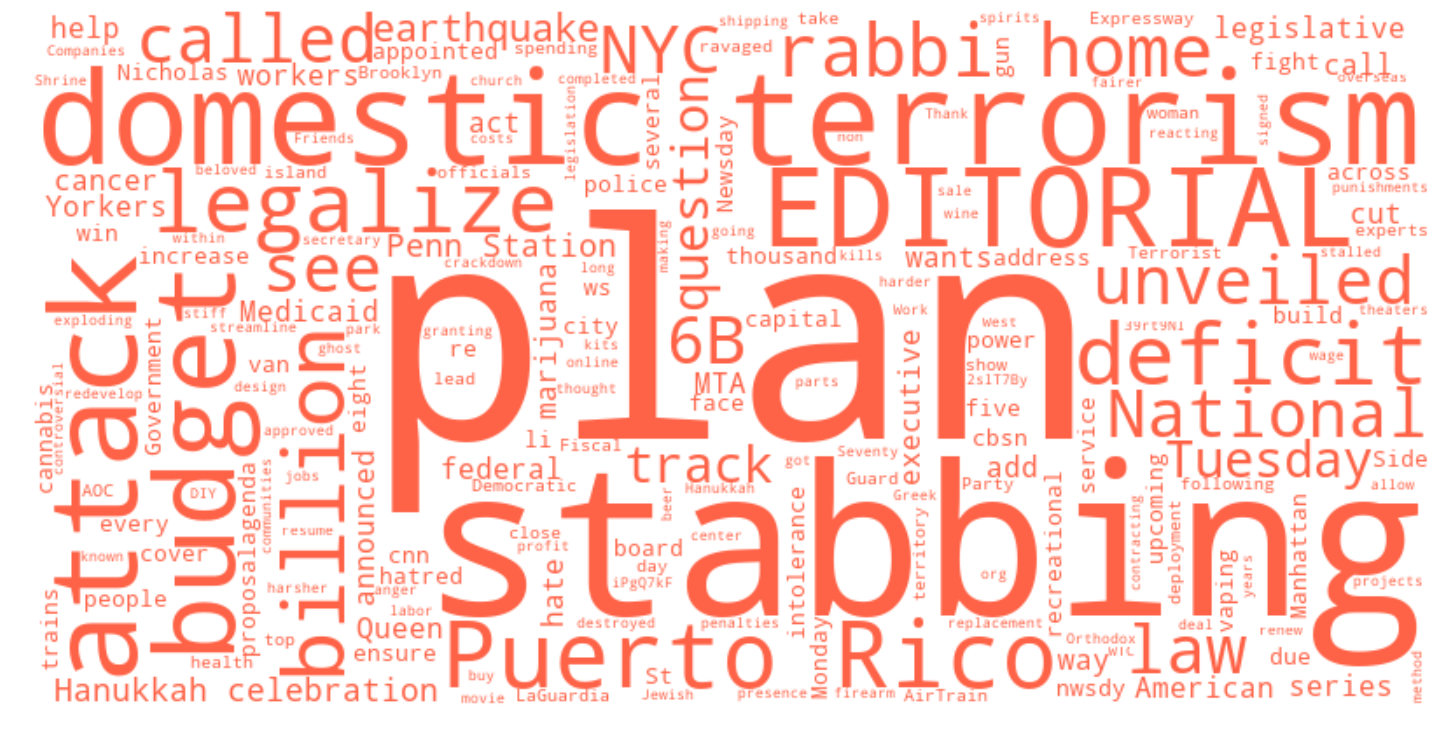

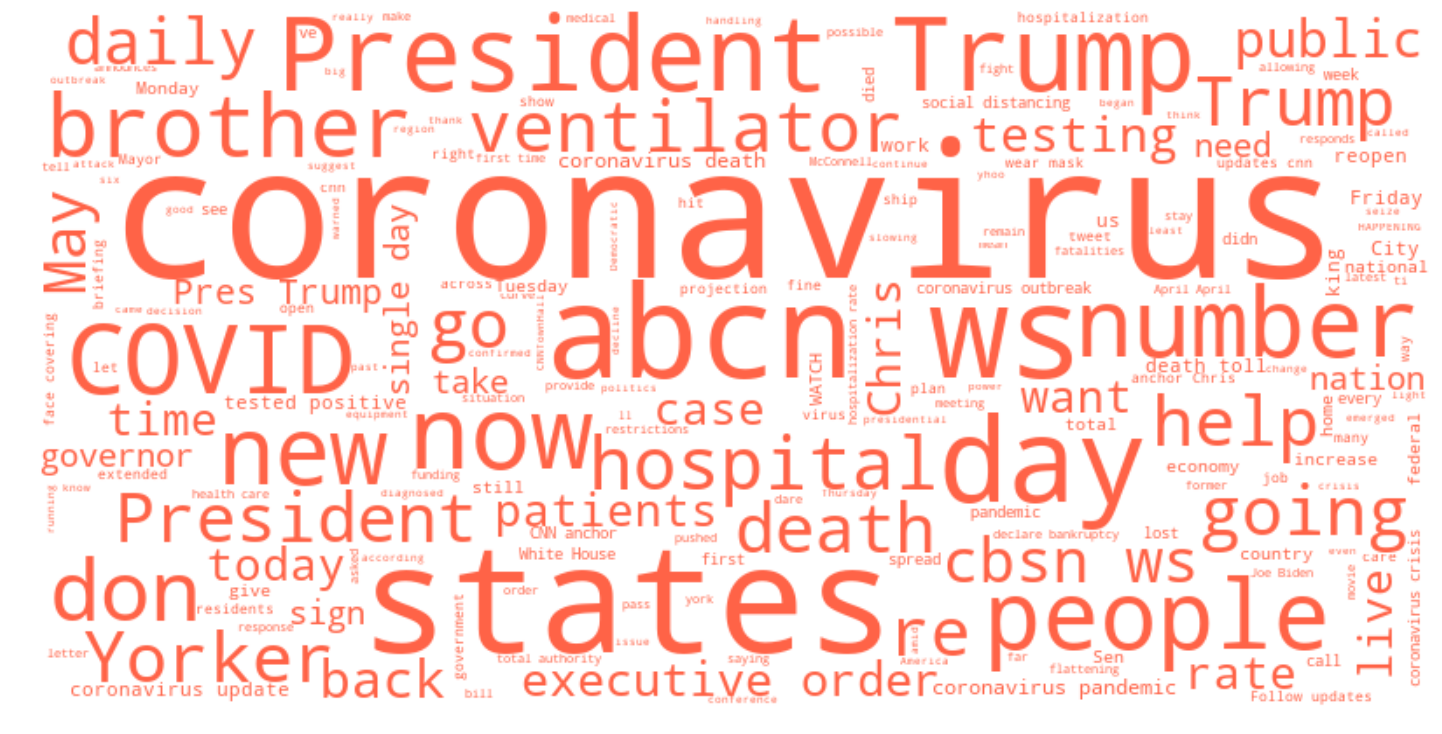

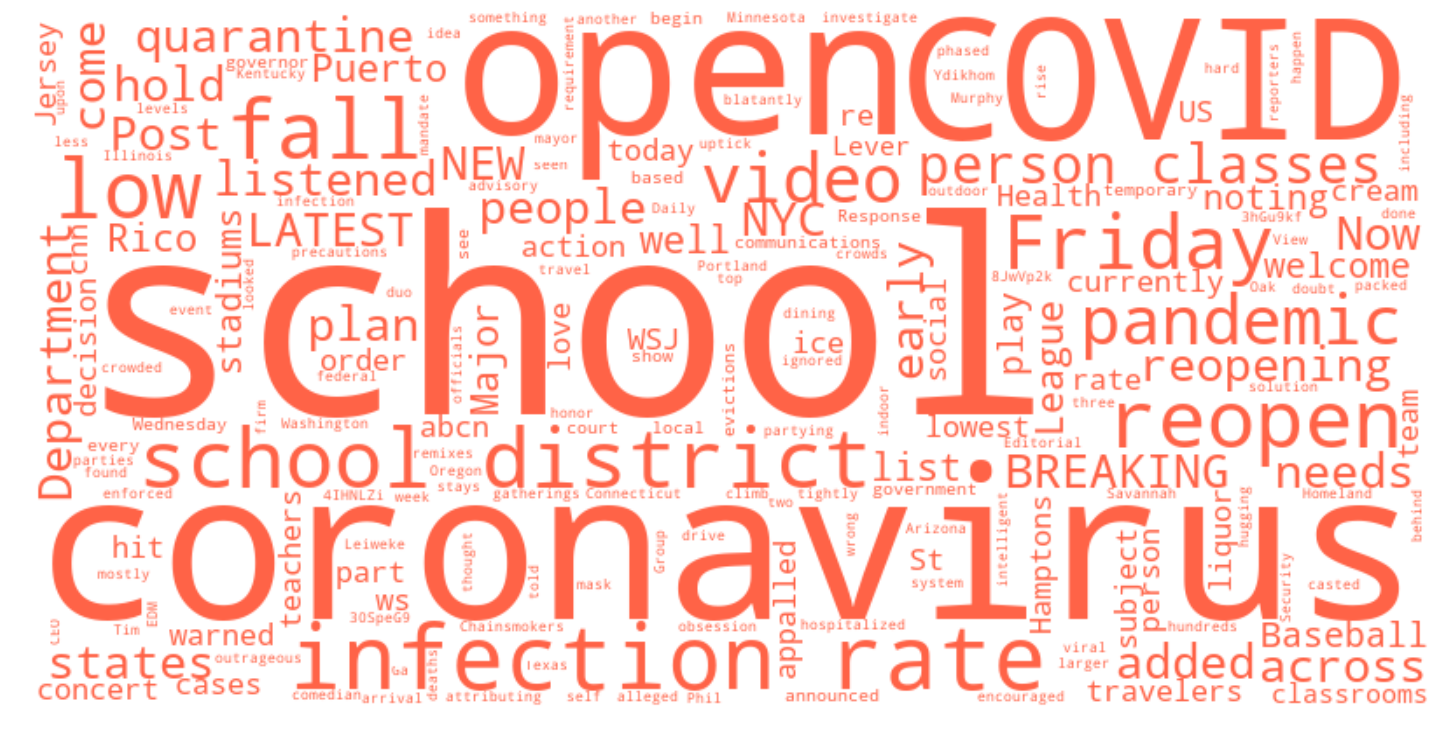

In [ ]:
cloud_states = ['New York']
cloud_months = [1,4,8] # jan apr aug
cloud_state_df_list = []

for state in cloud_states:
    for month in cloud_months:
        state_df =  tweets_df[tweets_df['State'].isin([state])]
        state_df['month'] = pd.DatetimeIndex(state_df['Unnamed: 0']).month
        state_df = state_df[state_df['month'].isin([month])]
        cloud_state_df_list.append(state_df)

words_in_color=lambda *args, **kwargs: (255,99,71)

for i,state in enumerate(cloud_state_df_list):
    allWords = ' '.join([twts for twts in state['Text']])
    excludedWords = ['al','will','new','year','one','say','said','says','NY','trib','https','live','watch','bit','ly','florida','Govenor','DeSantis','Ron','Gov DeSantis','Gov Ron','Florida','state','State','New York', 'new york', 'New', 'York', 'Cuomo', 'Andrew', 'cuomo', 'andrew', 'Gov', 'gov', 'Gov. Cuomo']
    usedWords = re.sub(r"[^a-zA-Z0-9]+", ' ',allWords).split()

    cloud  =  []
    for word in usedWords:
        if word in excludedWords:
            pass
        else:
            cloud.append(word)
    #[word for word in usedWords if word not in excludedWords]
    Cloud = ' '.join(cloud)

    wordCloud = WordCloud(background_color="white",width=800, height=400)#,random_state=21, max_font_size=110).generate(allWords)
    wordCloud = wordCloud.generate(Cloud)
    wordCloud.recolor(color_func = words_in_color)
    
    plt.figure(figsize=(20,10))
    plt.imshow(wordCloud, interpolation="bilinear")
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.savefig(f'cloud_{i}_orange.pdf', bbox_inches = 'tight', pad_inches = 0)
    plt.show()
    #wordCloud.to_file(f'cloud_{i}.pdf')


## 6.7 Collapse tweets data by week and state to get weekly polarity score

Here we aim at constructing a data frame that can be merged with the COVID/unemployment data frame that we already created. We do this by creating a copy of the tweets and then aggregating by week for each Governor. Note that the length of the df is only 298. Apparently for some of the weeks no tweets were collected for some Governors. This way, the tweet sentiment data can not be merged with the COVID/unemployment data due to the missing obs. The problem is solved in the following cells by imputation of 0s for the weeks without observations. We describe this approach in the report in section 3.

In [ ]:
gov_name_df_copy = tweets_df.copy()

gov_name_df_copy = gov_name_df_copy.reset_index().groupby(['Unnamed: 0','TinyTitle','State'])\
    .Polarity.agg('mean')\
    .reset_index()\
    .set_index('Unnamed: 0')
gov_name_df_copy.index.name = ''

print('Desired of rows: 320    ||   Number of obtained rows in weekly tweets df: ', len(gov_name_df_copy))
print('-----------------------------------------')
gov_name_df_copy

Desired of rows: 320    ||   Number of obtained rows in weekly tweets df:  298
-----------------------------------------


TinyTitle         State  Polarity
                                                 
2020-01-04  Gov. Abbott    Texas         0.045933
2020-01-04  Gov. Cuomo     New York      0.035747
2020-01-04  Gov. DeSantis  Florida       0.072750
2020-01-04  Gov. DeWine    Ohio          0.000000
2020-01-04  Gov. Newsom    California   -0.300000
...                 ...     ...               ...
2020-08-08  Gov. Kemp      Georgia       0.109453
2020-08-08  Gov. Newsom    California    0.103042
2020-08-08  Gov. Pritzker  Illinois     -0.073455
2020-08-08  Gov. Whitmer   Michigan      0.063696
2020-08-08  Gov. Wolf      Pennsylvania  0.050000

[298 rows x 3 columns]

# 7. Cleaning and merging all data

## 7.1 Imputation of missing observations with 0s

In this cells we create a new empty data frame and add a row with a polarity score of 0 for each week where data is missing. The resulting data frame has 22 rows. Note that this equals the difference between the obtained 298 rows in the weekly tweets df and the 320 rows in the COVID/unemployment df that we want combine. 

In [ ]:
missing_tweets_list = []

#Create a missing_tweets_list with one entry every time there is no tweet about a governor
for index in gov_name_df_copy.index.unique():
    missing_tweets = gov_df_10_big[~gov_df_10_big['TinyTitle'].isin(gov_name_df_copy.loc[index]['TinyTitle'])]
    missing_tweets['index'] = index
    missing_tweets['Polarity'] = 0
    missing_tweets.set_index('index')
    missing_tweets_list.append(missing_tweets)
    
#Create a dummy df missing_tweets_imputation_df from missing_tweets_list
missing_tweets_imputation_df = pd.concat(missing_tweets_list).set_index('index')[['TinyTitle','Polarity','State']]
missing_tweets_imputation_df.index.name = ''

print('Number of rows in missing tweets dummy df: ',len(missing_tweets_imputation_df))
print('-----------------------------------------')
missing_tweets_imputation_df

Number of rows in missing tweets dummy df:  22
-----------------------------------------


TinyTitle  Polarity           State
                                                   
2020-01-04  Gov. Kemp      0         Georgia       
2020-01-04  Gov. Cooper    0         North Carolina
2020-01-11  Gov. Cooper    0         North Carolina
2020-01-18  Gov. Cooper    0         North Carolina
2020-01-25  Gov. Cooper    0         North Carolina
2020-01-25  Gov. Wolf      0         Pennsylvania  
2020-02-01  Gov. Cooper    0         North Carolina
2020-02-01  Gov. DeWine    0         Ohio          
2020-02-08  Gov. Cooper    0         North Carolina
2020-02-08  Gov. Abbott    0         Texas         
2020-02-15  Gov. Pritzker  0         Illinois      
2020-02-15  Gov. Cooper    0         North Carolina
2020-02-22  Gov. Cooper    0         North Carolina
2020-03-14  Gov. Cooper    0         North Carolina
2020-03-21  Gov. Cooper    0         North Carolina
2020-04-11  Gov. Cooper    0         North Carolina
2020-04-18  Gov. Cooper    0         North Carolina
2020-05-09  Gov. Cooper    0         North Carolina
2020-05-16  Gov. Cooper    0         North Carolina
2020-06-20  Gov. Cooper    0         North Carolina
2020-07-18  Gov. Cooper    0         North Carolina
2020-08-01  Gov. Cooper    0         North Carolina

## 7.2 Adding imputed rows to weekly Twitter df

Now we impute the 22 rows into the tweets df. The result is a weekly twitter sentiment data frame with 320 rows that has the same shape, indix and identifier as the COVID/unemployment data. 

In [ ]:
polarity_df_final = pd.concat([missing_tweets_imputation_df, gov_name_df_copy],sort=True)
polarity_df_final = polarity_df_final.reset_index().sort_values('').set_index('')
polarity_df_final.head(20)

print('Number of rows in final polarity df: ',len(polarity_df_final))
print('-----------------------------------------')
polarity_df_final.head(10)

Number of rows in final polarity df:  320
-----------------------------------------


Polarity           State      TinyTitle
                                                   
2020-01-04  0.000000  Georgia         Gov. Kemp    
2020-01-04  0.072750  Florida         Gov. DeSantis
2020-01-04  0.000000  Ohio            Gov. DeWine  
2020-01-04 -0.300000  California      Gov. Newsom  
2020-01-04  0.288920  Illinois        Gov. Pritzker
2020-01-04 -0.031109  Michigan        Gov. Whitmer 
2020-01-04 -0.033350  Pennsylvania    Gov. Wolf    
2020-01-04  0.035747  New York        Gov. Cuomo   
2020-01-04  0.045933  Texas           Gov. Abbott  
2020-01-04  0.000000  North Carolina  Gov. Cooper

# 8. Merge COVID-enemployment df with polarity df

Now that the two data sets have the same format they can finally be merged. The final data frame is called final_df_320_rows.

In [ ]:
#Reduce COVID_unemployment data to top 10 US-States 
ten_biggest_states = ["California", "Texas", "Florida", "New York", "Illinois", "Pennsylvania", "Ohio", "Georgia", "North Carolina", "Michigan"]
corona_unemply_10_big =  big_df[big_df['State'].isin(ten_biggest_states)]#.sort_values('State').reset_index().drop('index', axis=1)

# merge both to final_df
corona_unemply_10_big = corona_unemply_10_big.reset_index().sort_values('')
polarity_df = polarity_df_final.reset_index()

# inner join on State names
final_df_320_rows = pd.merge(corona_unemply_10_big, polarity_df, how ='right',left_on=['','State'], right_on = ['','State'])

#Print final df
print('Number of rows in final df: ',len(final_df_320_rows))
print('-----------------------------------------')
final_df_320_rows.head(10)

Number of rows in final df:  320
-----------------------------------------


State  Insured Unemployment Rate  Weekly New Cases  \
0  2020-01-04  California      2.09                       0.0                
1  2020-01-04  Ohio            1.38                       0.0                
2  2020-01-04  Florida         0.42                       0.0                
3  2020-01-04  North Carolina  0.48                       0.0                
4  2020-01-04  Texas           1.16                       0.0                
5  2020-01-04  New York        1.94                       0.0                
6  2020-01-04  Georgia         0.89                       0.0                
7  2020-01-04  Michigan        1.68                       0.0                
8  2020-01-04  Pennsylvania    2.34                       0.0                
9  2020-01-04  Illinois        2.12                       0.0                

   Weekly Deaths  Polarity      TinyTitle  
0  0.0           -0.300000  Gov. Newsom    
1  0.0            0.000000  Gov. DeWine    
2  0.0            0.072750  Gov. DeSantis  
3  0.0            0.000000  Gov. Cooper    
4  0.0            0.045933  Gov. Abbott    
5  0.0            0.035747  Gov. Cuomo     
6  0.0            0.000000  Gov. Kemp      
7  0.0           -0.031109  Gov. Whitmer   
8  0.0           -0.033350  Gov. Wolf      
9  0.0            0.288920  Gov. Pritzker

In [ ]:
#Save final df to csv
final_df_320_rows.set_index('').to_csv("final_df_320_rows.csv")

# 9. Descriptive Statistics

Because we could not sumbit more than the report and the notebook, we can not provide the "final_df_320_rows.csv" as a file. Therefore we provide an import link where the df can be imported from Github below.

In [ ]:
#here we load the saved final df from Github 
final_df_320_rows = pd.read_csv('https://github.com/jacobshein/uploads/blob/master/final_df_320_rows.csv?raw=true', index_col='Unnamed: 0')#, error_bad_lines=False)#, index_col='Unnamed: 0')

In [ ]:
# Pearson's coeffcients
list_of_correlations = []
states_of_interest = ['California', 'Texas', 'Florida', 'New York']

for i,state in enumerate(states_of_interest):
  state_id = (final_df_320_rows['State'] == state)
  dataset = final_df_320_rows.loc[state_id][['Insured Unemployment Rate','Weekly New Cases','Weekly Deaths','Polarity','State']]
  dataset['Insured Unemployment Rate']
  dataset['Weekly New Cases']
  corr = np.corrcoef(dataset['Insured Unemployment Rate'], dataset['Weekly New Cases'])[0][1]
  list_of_correlations.append(np.round(corr,3))
    
print('Here are the Pearsons coeffcients between unemplyoment and weekly new COVID-19 cases in the following states: ')
print(states_of_interest)
print(list_of_correlations)

# Descriptive Statistics
colNamesDescrip = ['min','mean','std','max','variable']
descrip_df = pd.DataFrame(data=None, columns=colNamesDescrip)
state_id = (final_df_320_rows['State'].isin(states_of_interest))

actual_df = final_df_320_rows.loc[state_id][['Insured Unemployment Rate', 'Weekly New Cases', 'Weekly Deaths', 'Polarity','State']]
descrip_series1 = pd.Series(actual_df['Insured Unemployment Rate'].describe()[['min','mean','std','max']], index=colNamesDescrip).round(2)
descrip_series1['variable'] = 'Unemployment Rate (%)'
descrip_series2 = pd.Series(actual_df['Weekly New Cases'].describe()[['min','mean','std','max']], index=colNamesDescrip).round(2)
descrip_series2['variable'] = 'Weekly New Cases'
descrip_series3 = pd.Series(actual_df['Weekly Deaths'].describe()[['min','mean','std','max']], index=colNamesDescrip).round(2)
descrip_series3['variable'] = 'Weekly Deaths'
descrip_series4 = pd.Series(actual_df['Polarity'].describe()[['min','mean','std','max']], index=colNamesDescrip).round(2)
descrip_series4['variable'] = 'Polarity'

descrip_df = descrip_df.append(descrip_series1, ignore_index=True)
descrip_df = descrip_df.append(descrip_series2, ignore_index=True)
descrip_df = descrip_df.append(descrip_series3, ignore_index=True)
descrip_df = descrip_df.append(descrip_series4, ignore_index=True)
descrip_df = descrip_df.set_index('variable')
descrip_df.index.name = ''
descrip_df = descrip_df.rename(columns={"min": "Min", "mean": "Mean", "std": "Std. Dev.", "max": "Max"})
#descrip_df.to_latex('/content/drive/My Drive/IDS_2020/descrip_df.tex')  #export table for latex to directionary

print('------------------------------------')
print('The next table shows descriptive statistics for out whole sample:')
descrip_df # Descriptive Stats for variables of states_of_interest

Here are the Pearsons coeffcients between unemplyoment and weekly new COVID-19 cases in the following states: 
['California', 'Texas', 'Florida', 'New York']
[0.658, 0.657, 0.36, 0.267]
------------------------------------
The next table shows descriptive statistics for out whole sample:


Min      Mean  Std. Dev.       Max
                                                          
Unemployment Rate (%)  0.37  7.98      6.83       27.75   
Weekly New Cases       0.00  15967.91  22484.50   83058.00
Weekly Deaths          0.00  470.80    975.45     6566.00 
Polarity              -0.30  0.07      0.07       0.35

# 10. Plots

## Investigating difference in timing of case and unemployment development 

In [ ]:
#Definition of sub dfs that are needed for the next plot

idx_ny = final_df_320_rows['State'].isin(['New York']) 
idx_mich = final_df_320_rows['State'].isin(['Michigan']) 
idx_penn = final_df_320_rows['State'].isin(['Pennsylvania'])
idx_fl = final_df_320_rows['State'].isin(['Florida']) 
idx_tex = final_df_320_rows['State'].isin(['Texas']) 
idx_cali = final_df_320_rows['State'].isin(['California'])

new_york_df = final_df_320_rows.loc[idx_ny]
new_york_df = new_york_df[['Weekly New Cases','Insured Unemployment Rate']]
michigan_df = final_df_320_rows.loc[idx_mich]
michigan_df = michigan_df[['Weekly New Cases','Insured Unemployment Rate']]
penns_df = final_df_320_rows.loc[idx_penn]
penns_df = penns_df[['Weekly New Cases','Insured Unemployment Rate']]
texas_df = final_df_320_rows.loc[idx_tex]
texas_df = texas_df[['Weekly New Cases','Insured Unemployment Rate']]
florida_df = final_df_320_rows.loc[idx_fl]
florida_df = florida_df[['Weekly New Cases','Insured Unemployment Rate']]
cali_df = final_df_320_rows.loc[idx_cali]
cali_df = cali_df[['Weekly New Cases','Insured Unemployment Rate']]

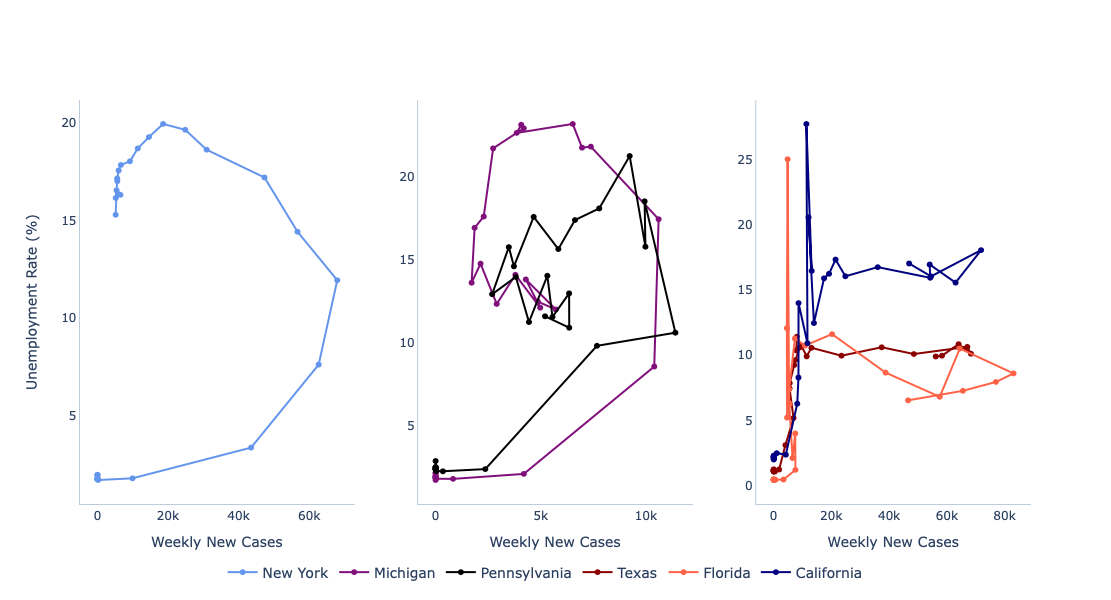

In [ ]:
fig3 = make_subplots(rows=1, cols=3)#,subplot_titles=("New York","North-eastern states", "States hit mainly after reopening"))

fig3.add_trace(go.Scatter(x=new_york_df['Weekly New Cases'], y=new_york_df['Insured Unemployment Rate'],
                    mode='lines+markers',
                    marker_color='cornflowerblue',
                    #color='DarkSlateGrey'),
                    name='New York'),
                    row=1, col=1)

fig3.add_trace(go.Scatter(x=michigan_df['Weekly New Cases'], y=michigan_df['Insured Unemployment Rate'],
                    mode='lines+markers',
                    name='Michigan',marker_color= 'rgb(129,15,124)'),row=1, col=2)
fig3.add_trace(go.Scatter(x=penns_df['Weekly New Cases'], y=penns_df['Insured Unemployment Rate'],
                    mode='lines+markers',
                    name='Pennsylvania',marker_color= 'black'),row=1, col=2)

fig3.add_trace(go.Scatter(x=texas_df['Weekly New Cases'], y=texas_df['Insured Unemployment Rate'],
                    mode='lines+markers',
                    name='Texas', marker_color='darkred'),row=1, col=3)
fig3.add_trace(go.Scatter(x=florida_df['Weekly New Cases'], y=florida_df['Insured Unemployment Rate'],
                    mode='lines+markers',
                    name='Florida', marker_color= 'tomato'),row=1, col=3)
fig3.add_trace(go.Scatter(x=cali_df['Weekly New Cases'], y=cali_df['Insured Unemployment Rate'],
                    mode='lines+markers',
                    name='California', marker_color='navy'),row=1, col=3)

fig3.update_layout(autosize=False,
    width=1000,
    height=600,
    plot_bgcolor="#FFF",
           xaxis=dict(title="Weekly New Cases",linecolor="#BCCCDC"),
           yaxis=dict(title="Unemployment Rate (%)",linecolor="#BCCCDC"),
           title={'xanchor': 'right','x': 1,'y':0.85}, 
           legend=dict(yanchor="top",y=-0.13, x=0.15, orientation = 'h',font=dict(size=14)),
           xaxis2=dict(title="Weekly New Cases",linecolor="#BCCCDC"),
           yaxis2=dict(linecolor="#BCCCDC"),
           xaxis3=dict(title="Weekly New Cases",linecolor="#BCCCDC"),
           yaxis3=dict(linecolor="#BCCCDC"))

#fig3.save_fig("Snails.pdf", bbox_inches = 'tight', pad_inches = 0)
fig3.show()
fig3.write_image("Snails.pdf")

In [1]:
#Note that there seems to be problems with showing plotly plots in jupyter notebooks for some user. 
#The code works as the graph is saved regardless but there might be an issue with a blank graph displayed in jupyter.

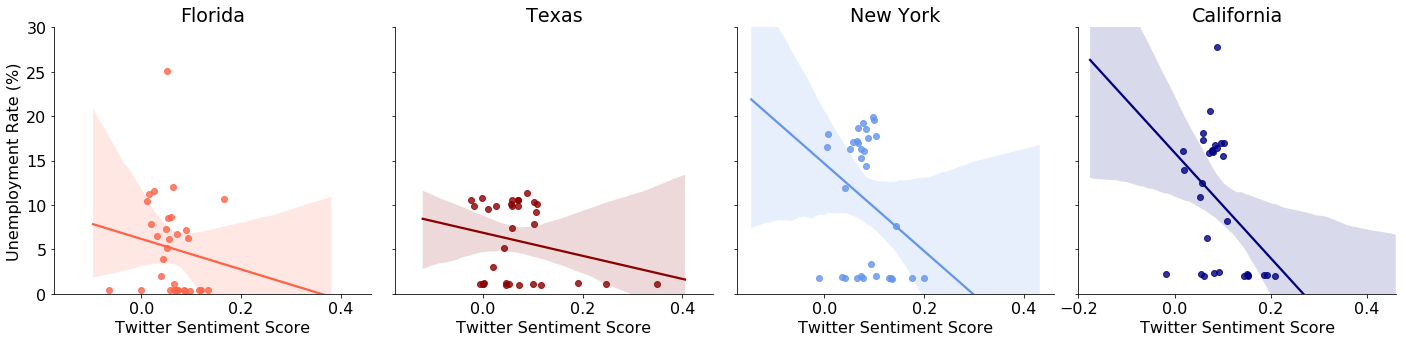

In [ ]:
idx_states = final_df_320_rows['State'].isin(['New York','Florida','California','Texas'])
#Note that first week (ending with 04.January 2020) was excluded because one extreme outlier in California that we consider to be a missclasification
lm = sns.lmplot('Polarity','Insured Unemployment Rate',col= 'State',hue ='State',data=final_df_320_rows.loc[idx_states][1:],palette={'New York': 'cornflowerblue', 'Florida':'tomato', 'California':'navy','Texas': 'darkred'})
lm.set_axis_labels("Twitter Sentiment Score", "Unemployment Rate (%)")
fig = lm.fig
pylab.ylim([0,30])
a1 = fig.axes[0]
a1.set_title("Florida")
a2 = fig.axes[1]
a2.set_title("Texas")
a3 = fig.axes[2]
a3.set_title("New York")
a4 = fig.axes[3]
a4.set_title("California")
#plt.ylabel('Unemployment rate (%)')
plt.xticks(np.arange(-0.2, 0.4, step=0.2))
plt.rcParams.update({'font.size': 25})
plt.show()
fig.savefig("Sentiment_vs_employment.pdf")

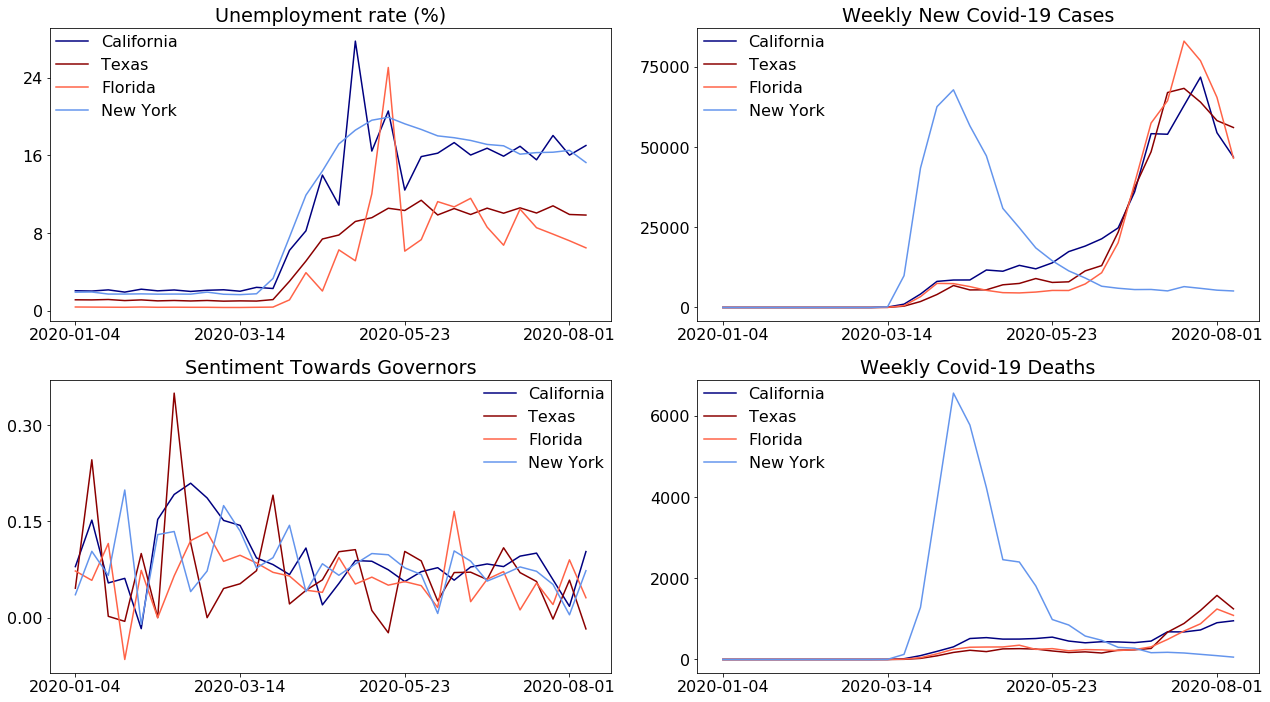

In [ ]:
# define unique week time indexes
unique_week = gov_name_df_copy.index.unique()
unique_week_indexes = list(unique_week)

# define unemployment series to plot
Florida_unemp_series = final_df_320_rows['Insured Unemployment Rate'].loc[final_df_320_rows['State'] == 'Florida']
Florida_unemp_series = Florida_unemp_series.reset_index().drop('index',axis = 1)
Florida_unemp_series['time'] = unique_week_indexes

texas_unemp_series = final_df_320_rows['Insured Unemployment Rate'].loc[final_df_320_rows['State'] == 'Texas']
texas_unemp_series = texas_unemp_series.reset_index().drop('index',axis = 1)
texas_unemp_series['time'] = unique_week_indexes

newyork_unemp_series = final_df_320_rows['Insured Unemployment Rate'].loc[final_df_320_rows['State'] == 'New York']
newyork_unemp_series = newyork_unemp_series.reset_index().drop('index',axis = 1)
newyork_unemp_series['time'] = unique_week_indexes

california_unemp_series = final_df_320_rows['Insured Unemployment Rate'].loc[final_df_320_rows['State'] == 'California']
california_unemp_series = california_unemp_series.reset_index().drop('index',axis = 1)
california_unemp_series['time'] = unique_week_indexes


#define covid_cases series to plot
Florida_cases_series = final_df_320_rows['Weekly New Cases'].loc[final_df_320_rows['State'] == 'Florida']
Florida_cases_series = Florida_cases_series.reset_index().drop('index',axis = 1)
Florida_cases_series['time'] = unique_week_indexes

texas_cases_series = final_df_320_rows['Weekly New Cases'].loc[final_df_320_rows['State'] == 'Texas']
texas_cases_series = texas_cases_series.reset_index().drop('index',axis = 1)
texas_cases_series['time'] = unique_week_indexes

newyork_cases_series = final_df_320_rows['Weekly New Cases'].loc[final_df_320_rows['State'] == 'New York']
newyork_cases_series = newyork_cases_series.reset_index().drop('index',axis = 1)
newyork_cases_series['time'] = unique_week_indexes

california_cases_series = final_df_320_rows['Weekly New Cases'].loc[final_df_320_rows['State'] == 'California']
california_cases_series = california_cases_series.reset_index().drop('index',axis = 1)
california_cases_series['time'] = unique_week_indexes

#define covid-deaths
Florida_deaths_series = final_df_320_rows['Weekly Deaths'].loc[final_df_320_rows['State'] == 'Florida']
Florida_deaths_series = Florida_deaths_series.reset_index().drop('index',axis = 1)
Florida_deaths_series['time'] = unique_week_indexes

texas_deaths_series = final_df_320_rows['Weekly Deaths'].loc[final_df_320_rows['State'] == 'Texas']
texas_deaths_series = texas_deaths_series.reset_index().drop('index',axis = 1)
texas_deaths_series['time'] = unique_week_indexes

newyork_deaths_series = final_df_320_rows['Weekly Deaths'].loc[final_df_320_rows['State'] == 'New York']
newyork_deaths_series = newyork_deaths_series.reset_index().drop('index',axis = 1)
newyork_deaths_series['time'] = unique_week_indexes

california_deaths_series = final_df_320_rows['Weekly Deaths'].loc[final_df_320_rows['State'] == 'California']
california_deaths_series = california_deaths_series.reset_index().drop('index',axis = 1)
california_deaths_series['time'] = unique_week_indexes

#define sentiment series to plot
Florida_sentiment_series = final_df_320_rows['Polarity'].loc[final_df_320_rows['State'] == 'Florida']
Florida_sentiment_series = Florida_sentiment_series.reset_index().drop('index',axis = 1)
Florida_sentiment_series['time'] = unique_week_indexes

texas_sentiment_series = final_df_320_rows['Polarity'].loc[final_df_320_rows['State'] == 'Texas']
texas_sentiment_series = texas_sentiment_series.reset_index().drop('index',axis = 1)
texas_sentiment_series['time'] = unique_week_indexes

newyork_sentiment_series = final_df_320_rows['Polarity'].loc[final_df_320_rows['State'] == 'New York']
newyork_sentiment_series = newyork_sentiment_series.reset_index().drop('index',axis = 1)
newyork_sentiment_series['time'] = unique_week_indexes

california_sentiment_series = final_df_320_rows['Polarity'].loc[final_df_320_rows['State'] == 'California']
california_sentiment_series[0] = np.mean(california_sentiment_series) #Crazy outlier correction
california_sentiment_series = california_sentiment_series.reset_index().drop('index',axis = 1)
california_sentiment_series['time'] = unique_week_indexes

#-------------------------------------------------------------------------------------------------

f,ax = plt.subplots(2, 2,figsize=(18,10))
plt.rcParams.update({'font.size': 16})
plt.rc('xtick', labelsize=16)     
plt.rc('ytick', labelsize=16)
    
#Unemployment
ax[0, 0].plot(california_unemp_series.set_index('time'), color='navy', label='California')
ax[0, 0].plot(texas_unemp_series.set_index('time'), color='darkred', label='Texas')
ax[0, 0].plot(Florida_unemp_series.set_index('time'), color='tomato', label='Florida')
ax[0, 0].plot(newyork_unemp_series.set_index('time'), color='cornflowerblue', label='New York')
ax[0, 0].set_title('Unemployment rate (%)')
leg = ax[0, 0].legend(loc='upper left', frameon=False, borderaxespad=0.)

#Sentiment
ax[1, 0].plot(california_sentiment_series.set_index('time'), color='navy', label='California')
ax[1, 0].plot(texas_sentiment_series.set_index('time'), color='darkred', label='Texas')
ax[1, 0].plot(Florida_sentiment_series.set_index('time'), color='tomato', label='Florida')
ax[1, 0].plot(newyork_sentiment_series.set_index('time'), color='cornflowerblue',  label='New York')
ax[1, 0].set_title('Sentiment Towards Governors')
leg = ax[1, 0].legend(loc='upper right', frameon=False, borderaxespad=0.)

#Weekly New Covid Cases
ax[0, 1].plot(california_cases_series.set_index('time'), color='navy', label='California')
ax[0, 1].plot(texas_cases_series.set_index('time'), color='darkred', label='Texas')
ax[0, 1].plot(Florida_cases_series.set_index('time'), color='tomato',  label='Florida')
ax[0, 1].plot(newyork_cases_series.set_index('time'), color='cornflowerblue', label='New York')
ax[0, 1].set_title('Weekly New Covid-19 Cases')
leg = ax[0, 1].legend(loc='upper left', frameon=False, borderaxespad=0.)

#Weekly New Covid Deaths
ax[1, 1].plot(california_deaths_series.set_index('time'), color='navy', label='California')
ax[1, 1].plot(texas_deaths_series.set_index('time'), color='darkred', label='Texas')
ax[1, 1].plot(Florida_deaths_series.set_index('time'), color='tomato', label='Florida')
ax[1, 1].plot(newyork_deaths_series.set_index('time'), color='cornflowerblue', label='New York')
ax[1, 1].set_title('Weekly Covid-19 Deaths')
leg = ax[1, 1].legend(loc='upper left', frameon=False, borderaxespad=0.)

for axi in ax.flat:
    axi.xaxis.set_major_locator(plt.MaxNLocator(4))
    axi.yaxis.set_major_locator(plt.MaxNLocator(4))

f.tight_layout(pad=1.0)

plt.savefig('timeseries_all_variables.pdf', bbox_inches = 'tight', pad_inches = 0)

# Heatmaps

In [ ]:
#Creating variable for new covid cases/population

#Reading population data from US census
population = pd.read_csv("nst-est2019-alldata.csv") 

#Renaming to match Covid-19 and unemployment data
rename = {'NAME':'State', 'CENSUS2010POP':'Population'}
population.rename(columns = rename, inplace=True)

#Dropping non-relevant regions
nregions=['United States', 'Northeast Region', 'Midwest Region', 'South Region', 'West Region' ]
for n in nregions:
    indexNames = population[population['State'] == n].index
    population.drop(indexNames , inplace=True)

# Creating dataframes for separate weeks
ealiest = big_df.loc[ '2020-01-04' , : ]
medium = big_df.loc[ '2020-04-04' , : ]
latest = big_df.loc[ '2020-08-08' , : ]

#joining them with population
jan_df = population.set_index('State').join(ealiest.set_index('State'))
jan_df = jan_df.reset_index()
apr_df = population.set_index('State').join(medium.set_index('State'))
apr_df = apr_df.reset_index()
aug_df= population.set_index('State').join(latest.set_index('State'))
aug_df = aug_df.reset_index()

#Creating new cases by population
jan_df['Cases per 100,000 people'] = jan_df.apply(lambda row: row['Weekly New Cases'] / 
                                  row.Population * 100000, axis = 1) 
apr_df['Cases per 100,000 people'] = apr_df.apply(lambda row: row['Weekly New Cases'] / 
                                  row.Population * 100000, axis = 1) 
aug_df['Cases per 100,000 people'] = aug_df.apply(lambda row: row['Weekly New Cases'] / 
                                  row.Population * 100000, axis = 1) 
aug_df

State  Population  Insured Unemployment Rate  \
0                Alabama     4779736                       3.64   
1                 Alaska      710231                      11.16   
2                Arizona     6392017                       7.55   
3               Arkansas     2915918                       5.21   
4             California    37253956                      17.02   
5               Colorado     5029196                       7.41   
6            Connecticut     3574097                      14.00   
7               Delaware      897934                       8.06   
8   District of Columbia      601723                        NaN   
9                Florida    18801310                       6.50   
10               Georgia     9687653                      12.99   
11                Hawaii     1360301                      19.96   
12                 Idaho     1567582                       2.72   
13              Illinois    12830632                      10.43   
14               Indiana     6483802                       6.54   
15                  Iowa     3046355                       6.01   
16                Kansas     2853118                       5.15   
17              Kentucky     4339367                       7.48   
18             Louisiana     4533372                      15.87   
19                 Maine     1328361                       8.37   
20              Maryland     5773552                       7.62   
21         Massachusetts     6547629                      12.76   
22              Michigan     9883640                      12.43   
23             Minnesota     5303925                       9.05   
24           Mississippi     2967297                      12.50   
25              Missouri     5988927                       5.36   
26               Montana      989415                       6.03   
27              Nebraska     1826341                       4.06   
28                Nevada     2700551                      24.20   
29         New Hampshire     1316470                       8.40   
30            New Jersey     8791894                      10.57   
31            New Mexico     2059179                      11.63   
32              New York    19378102                      15.27   
33        North Carolina     9535483                       5.49   
34          North Dakota      672591                       4.95   
35                  Ohio    11536504                       7.06   
36              Oklahoma     3751351                       8.27   
37                Oregon     3831074                       9.11   
38          Pennsylvania    12702379                      11.55   
39          Rhode Island     1052567                      11.80   
40        South Carolina     4625364                       8.17   
41          South Dakota      814180                       3.51   
42             Tennessee     6346105                       6.79   
43                 Texas    25145561                       9.87   
44                  Utah     2763885                       3.90   
45               Vermont      625741                      10.48   
46              Virginia     8001024                       7.05   
47            Washington     6724540                       9.12   
48         West Virginia     1852994                       8.70   
49             Wisconsin     5686986                       6.31   
50               Wyoming      563626                       4.20   
51           Puerto Rico     3725789                        NaN   

    Weekly New Cases  Weekly Deaths  Cases per 100,000 people  
0              477.0            2.0                  9.979631  
1            10824.0          152.0               1524.011202  
2             9105.0          390.0                142.443301  
3             5638.0           75.0                193.352488  
4            46894.0          954.0                125.876565  
5             3057.0           13.0                 60.785064  
6              510.

In [ ]:
#Importing data on US locations of states
fp = "states.shp"
map_df = gdp.read_file(fp)

#Dropping irrelevant data
drop = ['DRAWSEQ', 'STATE_FIPS', 'SUB_REGION', 'STATE_ABBR']
map_df = map_df.drop(drop, axis = 1)


#Renaming to match Covid-19 and unemployment data
rename = {'STATE_NAME':'State'}
map_df.rename(columns = rename, inplace=True)

#Dropping Hawaii and Alaska
indexNames = map_df[ map_df['State'] == 'Alaska' ].index
map_df.drop(indexNames , inplace=True)
indexNames = map_df[ map_df['State'] == 'Hawaii' ].index
map_df.drop(indexNames , inplace=True)
map_df.head()
#map_df.plot()

State                                           geometry
1    Washington  MULTIPOLYGON (((-122.40202 48.22522, -122.4628...
2       Montana  POLYGON ((-111.47543 44.70216, -111.48080 44.6...
3         Maine  MULTIPOLYGON (((-69.77728 44.07415, -69.85993 ...
4  North Dakota  POLYGON ((-98.73044 45.93827, -99.00683 45.939...
5  South Dakota  POLYGON ((-102.78838 42.99530, -103.00588 42.9...

In [ ]:
#Merging data by states
big_df_jan = map_df.set_index('State').join(jan_df.set_index('State'))
big_df_apr = map_df.set_index('State').join(apr_df.set_index('State'))
big_df_aug= map_df.set_index('State').join(aug_df.set_index('State'))

big_df_aug

geometry  \
State                                                                     
Washington            MULTIPOLYGON (((-122.40202 48.22522, -122.4628...   
Montana               POLYGON ((-111.47543 44.70216, -111.48080 44.6...   
Maine                 MULTIPOLYGON (((-69.77728 44.07415, -69.85993 ...   
North Dakota          POLYGON ((-98.73044 45.93827, -99.00683 45.939...   
South Dakota          POLYGON ((-102.78838 42.99530, -103.00588 42.9...   
Wyoming               POLYGON ((-104.05362 41.69822, -104.05550 41.5...   
Wisconsin             MULTIPOLYGON (((-87.74856 44.96162, -87.83999 ...   
Idaho                 POLYGON ((-117.02630 43.67903, -117.02379 43.7...   
Vermont               POLYGON ((-73.25806 42.74606, -73.26928 42.747...   
Minnesota             POLYGON ((-91.73037 43.49957, -92.07753 43.499...   
Oregon                POLYGON ((-121.44151 41.99433, -122.28471 42.0...   
New Hampshire         POLYGON ((-72.27992 42.72047, -72.45577 42.725...   
Iowa                  POLYGON ((-91.12013 40.70544, -91.12930 40.682...   
Massachusetts         MULTIPOLYGON (((-71.31933 41.77220, -71.33980 ...   
Nebraska              POLYGON ((-101.40739 40.00100, -102.05154 39.9...   
New York              MULTIPOLYGON (((-79.76324 42.26733, -79.44402 ...   
Pennsylvania          POLYGON ((-77.47579 39.71962, -78.09595 39.725...   
Connecticut           POLYGON ((-73.53039 41.52275, -73.51715 41.665...   
Rhode Island          MULTIPOLYGON (((-71.79019 41.60131, -71.79261 ...   
New Jersey            POLYGON ((-75.48928 39.71486, -75.47597 39.720...   
Indiana               POLYGON ((-86.34161 38.17729, -86.36435 38.193...   
Nevada                POLYGON ((-119.15245 38.41180, -119.31883 38.5...   
Utah                  POLYGON ((-114.04727 38.13765, -114.04509 38.5...   
California            MULTIPOLYGON (((-121.66522 38.16929, -121.7823...   
Ohio                  POLYGON ((-83.27276 38.60926, -83.29004 38.596...   
Illinois              POLYGON ((-88.07159 37.51104, -88.08791 37.476...   
District of Columbia  POLYGON ((-77.00793 38.96667, -76.91090 38.890...   
Delaware              POLYGON ((-75.70707 38.55759, -75.71071 38.649...   
West Virginia         POLYGON ((-79.23166 38.48050, -79.27236 38.437...   
Maryland              MULTIPOLYGON (((-75.71071 38.64967, -75.70707 ...   
Colorado              POLYGON ((-102.04446 37.64147, -102.04201 37.3...   
Kentucky              MULTIPOLYGON (((-86.51067 36.65507, -86.77054 ...   
Kansas                POLYGON ((-95.07193 37.00148, -95.40662 37.000...   
Virginia              MULTIPOLYGON (((-79.14406 36.54620, -79.21680 ...   
Missouri              POLYGON ((-89.10503 36.95392, -89.12965 36.866...   
Arizona               POLYGON ((-114.52063 33.02771, -114.55909 33.0...   
Oklahoma              POLYGON ((-94.43932 34.92915, -94.44596 34.735...   
North Carolina        MULTIPOLYGON (((-83.98845 34.98915, -84.11815 ...   
Tennessee             POLYGON ((-83.95461 35.45554, -84.01256 35.407...   
Texas                 MULTIPOLYGON (((-105.99889 31.39394, -106.2132...   
New Mexico            POLYGON ((-109.04950 32.44204, -109.05135 32.7...   
Alabama               POLYGON ((-85.07007 31.98070, -85.11515 31.907...   
Mississippi           POLYGON ((-88.45080 31.43562, -88.43456 31.120...   
Georgia               MULTIPOLYGON (((-85.13017 31.77885, -85.13156 ...   
South Carolina        MULTIPOLYGON (((-81.75959 33.19538, -81.76988 ...   
Arkansas              POLYGON ((-94.46169 34.19677, -94.45262 34.508...   
Louisiana             MULTIPOLYGON (((-93.70752 30.23958, -93.69938 ...   
Florida               MULTIPOLYGON (((-80.78566 28.78519, -80.76242 ...   
Michigan              MULTIPOLYGON (((-88.49753 48.17380, -88.62533 ...   

                      Population  Insured Unemployment Rate  Weekly New Cases  \
State                                                                           
Washington               6724540                       9.12            5143

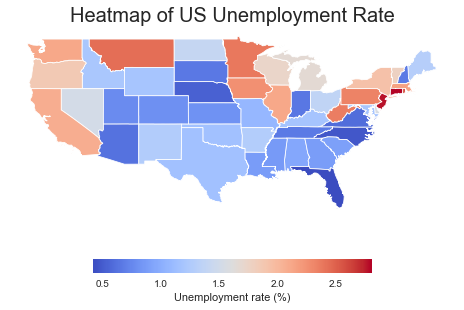

In [ ]:
# i. Setting the colour of the municipality to be determined by the rank
variable2 = 'Insured Unemployment Rate'

# ii. Setting the range for the colours
vmin, vmax = 0, 5

# iii. Creating the figure backdrop
fig, ax = plt.subplots(1, figsize=(10, 5))
ax.axis('off')

# iv. Setting the title
ax.set_title('Heatmap of US Unemployment Rate', fontdict={'fontsize':'20', 'fontweight':'3'})

# v. Creating map
big_df_jan.plot(column=variable2, cmap='coolwarm', linewidth=0.8, ax=ax, edgecolor='1', legend=True, legend_kwds={'label': "Unemployment rate (%)", 'orientation': "horizontal", 'shrink':0.5})

#vi. Saving file
plt.savefig('hm_unemp_jan.pdf', bbox_inches = 'tight', pad_inches = 0)

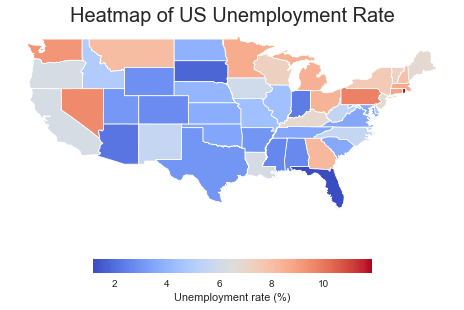

In [ ]:
# i. Setting the colour of the municipality to be determined by the rank
variable2 = 'Insured Unemployment Rate'

# ii. Setting the range for the colours
vmin, vmax = 0, 15

# iii. Creating the figure backdrop
fig, ax = plt.subplots(1, figsize=(10, 5))
ax.axis('off')

# iv. Giving a title and footnote
ax.set_title('Heatmap of US Unemployment Rate', fontdict={'fontsize':'20', 'fontweight':'3'})

# v. Creating map
big_df_apr.plot(column=variable2, cmap='coolwarm', linewidth=0.8, ax=ax, edgecolor='1', legend=True, legend_kwds={'label': "Unemployment rate (%)", 'orientation': "horizontal",'shrink':0.5})

#vi. Saving file
plt.savefig('hm_unemp_apr.pdf', bbox_inches = 'tight', pad_inches = 0)

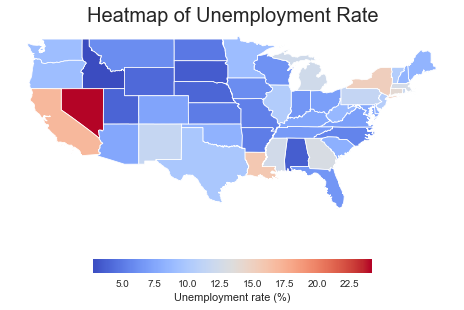

In [ ]:
# i. Setting the colour of the municipality to be determined by the rank
variable2 = 'Insured Unemployment Rate'

# ii. Setting the range for the colours
vmin, vmax = 6, 20

# iii. Creating the figure backdrop
fig, ax = plt.subplots(1, figsize=(10, 5))
ax.axis('off')

# iv. Setting the title
ax.set_title('Heatmap of Unemployment Rate', fontdict={'fontsize':'20', 'fontweight':'3'})

# v. Creating map
big_df_aug.plot(column=variable2, cmap='coolwarm', linewidth=0.8, ax=ax, edgecolor='1', legend=True, legend_kwds={'label': "Unemployment rate (%)", 'orientation': "horizontal", 'shrink':0.5})

#vi. Saving file
plt.savefig('hm_unemp_aug.pdf', bbox_inches = 'tight', pad_inches = 0)

/Users/metteandresen1/opt/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


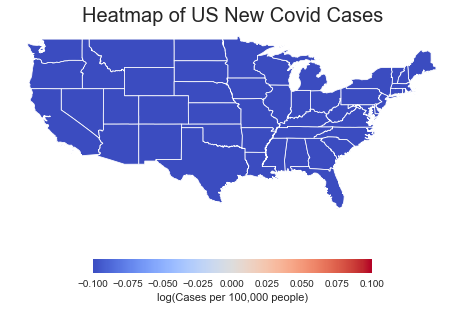

In [ ]:
# i. Setting the colour of the municipality to be determined by the rank
variable2 = 'Cases per 100,000 people'

# ii. Setting the range for the colours
vmin, vmax = 0, 7

# iii. Creating the figure backdrop
fig, ax = plt.subplots(1, figsize=(10, 5))
ax.axis('off')

# iv. Setting the title
ax.set_title('Heatmap of US New Covid Cases', fontdict={'fontsize':'20', 'fontweight':'3'})

# v. Creating map
big_df_jan.plot(np.log(big_df_jan[variable2]), cmap='coolwarm', linewidth=0.8, ax=ax, edgecolor='1', legend=True, legend_kwds={'label': "log(Cases per 100,000 people)", 'orientation': "horizontal", 'shrink':0.5})

#vi. Saving file
plt.savefig('hm_covid_jan.pdf', bbox_inches = 'tight', pad_inches = 0)

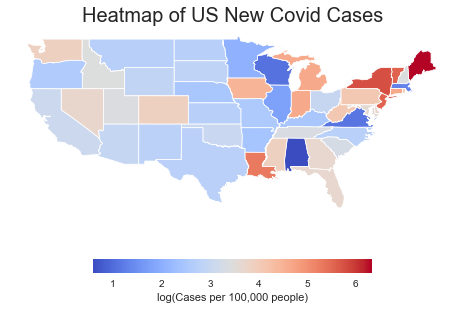

In [ ]:
# i. Setting the colour of the municipality to be determined by the rank
variable2 = 'Cases per 100,000 people'

# ii. Setting the range for the colours
vmin, vmax = 0, 7

# iii. Creating the figure backdrop
fig, ax = plt.subplots(1, figsize=(10,5))
ax.axis('off')

# iv. Setting the title
ax.set_title('Heatmap of US New Covid Cases', fontdict={'fontsize':'20', 'fontweight':'3'})

# v. Creating map
big_df_apr.plot(np.log(big_df_apr[variable2]), cmap='coolwarm', linewidth=0.8, ax=ax, edgecolor='1', legend=True, legend_kwds={'label': "log(Cases per 100,000 people)", 'orientation': "horizontal", 'shrink':0.5})

#vi. Saving file
plt.savefig('hm_covid_apr.pdf', bbox_inches = 'tight', pad_inches = 0)

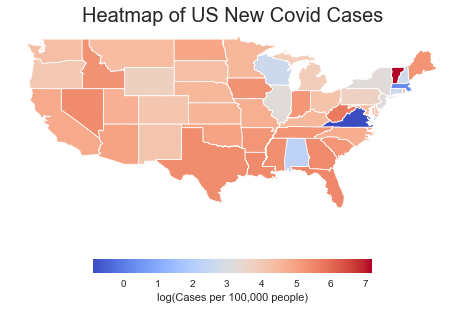

In [ ]:
# i. Setting the colour of the municipality to be determined by the rank
variable2 = 'Cases per 100,000 people'

# ii. Setting the range for the colours
vmin, vmax = 0, 7

# iii. Creating the figure backdrop
fig, ax = plt.subplots(1, figsize=(10,5))
ax.axis('off')

# iv. Setting the title
ax.set_title('Heatmap of US New Covid Cases', fontdict={'fontsize':'20', 'fontweight':'3'})

# v. Creating map
big_df_aug.plot(np.log(big_df_aug[variable2]), cmap='coolwarm', linewidth=0.8, ax=ax, edgecolor='1', legend=True, legend_kwds={'label': "log(Cases per 100,000 people)", 'orientation': "horizontal", 'shrink':0.5})

#vi. Saving file
plt.savefig('hm_covid_aug.pdf', bbox_inches = 'tight', pad_inches = 0)

# 11. LSTM Models: Keras Implementation

In [ ]:
def lag_data(data, n_in=1, n_out=1, dropnan=True):

	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
 
	# # creating the time sequence back in time
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]

	# creating the time sequence ahead
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# concat the cols
	agg = concat(cols, axis=1)
	agg.columns = names
	# dropping NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

# load scraped and retrieved unemployment, COVID-19 and Twitter data
df = pd.read_csv('https://github.com/jacobshein/uploads/blob/master/final_df_320_rows.csv?raw=true', index_col='Unnamed: 0')
states_of_interest = ['California', 'Texas', 'Florida', 'New York']

# scale features into (0,1) ranges
scaler = MinMaxScaler(feature_range=(0, 1))

def lag_variables_for_states_of_interest(states_of_interest):
  one_week_lagged_dataframes = []
  for state in states_of_interest:
    
    # iterate through all states of interest
    state_id = (df['State'] == state)
    dataset = df.loc[state_id][['Insured Unemployment Rate','Weekly New Cases','Weekly Deaths','Polarity']]
    values = dataset.values

    # data should be floating points
    values = values.astype('float32')

    # scale and lag variables
    variable_lag = 1
    scaled = scaler.fit_transform(values)
    reframed = lag_data(scaled, variable_lag, 1)

    # drop columns and keep the lagged 1 week variables
    reframed = reframed[['var1(t-1)', 'var2(t-1)', 'var3(t-1)', 'var4(t-1)', 'var1(t)']]
    one_week_lagged_dataframes.append(reframed)
  return one_week_lagged_dataframes

reframed_dfs = lag_variables_for_states_of_interest(states_of_interest)


def split_train_val_test(reframed_df):
  values = reframed_df.values
  n_val_weeks = 3
  n_test_weeks = 6
  n_train_weeks = 32 - n_val_weeks - n_test_weeks
  train = values[:n_train_weeks, :]
  validation = values[n_train_weeks:-n_test_weeks, :]
  test = values[n_train_weeks+n_val_weeks:, :]

  # split into train, val and test
  train_X, train_y = train[:, :-1], train[:, -1]
  val_X, val_y = validation[:, :-1], validation[:, -1]
  test_X, test_y = test[:, :-1], test[:, -1]

  # reshaping input data into 3D [samples, timesteps, features]
  train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
  val_X = val_X.reshape((val_X.shape[0], 1, val_X.shape[1]))
  test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

  #print(train_X.shape, train_y.shape, val_X.shape, val_y.shape, test_X.shape, test_y.shape)
  return train_X, train_y, val_X, val_y, test_X, test_y

train_X, train_y, val_X, val_y, test_X, test_y = split_train_val_test(reframed_dfs[0])

In [ ]:
# LSTM Model Training and Validation
# Regularizer lambda values for validation
lambdas = [1e-1, 1e-2, 0] 
pat = 10 # Patience for Early Stopping criteria, i.e. number of epochs we check for loss convergence before terminating training
max_epochs = 300
best_models = []

for i,state in enumerate(states_of_interest):
  print(f"Model Training & Validation for {state}")
  print("===================================")
  train_X, train_y, val_X, val_y, test_X, test_y = split_train_val_test(reframed_dfs[i])
  for lamb in lambdas:

    reg = regularizers.l2(lamb)


    # Initialization of parameters to avoid local minima. 
    # Seed used for same and fair initialization of across all model reruns:
    Initializer = initializers.glorot_normal(seed=1)

    model = Sequential()
    model.add(LSTM(50, kernel_regularizer=reg, activation='relu', input_shape=(train_X.shape[1], train_X.shape[2]), 
                          kernel_initializer=Initializer))
    model.add(Dense(1))
    loss_to_monitor = 'val_loss'
    early_stopping = EarlyStopping(monitor=loss_to_monitor, mode='min',
                                  patience=pat, verbose=0)

    model_name = f'{state}_Reg_{lamb}_.h5'
    model_checkpoint = ModelCheckpoint(model_name, monitor=loss_to_monitor,
                                      mode='min', verbose=0, 
                                      save_best_only=True)
    model.compile(loss='mae', optimizer='adam')
    history = model.fit(train_X, train_y, validation_data=(val_X, val_y), 
              epochs=max_epochs, batch_size=6, verbose=1, 
              callbacks=[early_stopping, model_checkpoint], 
              shuffle=False)
    
    model = load_model(model_name)
    model.save(f'/content/drive/My Drive/IDS_2020/SavedModels/{model_name}',save_format='h5')

    val_loss_current_model = model.evaluate(val_X, val_y)

    bm_string = "Model of : ", model_name, " Val loss: ", round(val_loss_current_model,3)
    print(bm_string)
    bm_string = pd.Series(bm_string)
    best_models.append(bm_string)

best_models_overview = pd.concat(best_models,axis=1)
best_models_overview.to_excel('/content/drive/My Drive/IDS_2020/SavedModels/BestModelsOverview.xlsx')

print("Validation of models and regularization parameters done...")

Model Training & Validation for New York
Epoch 1/300
4/4 [==============================] - 0s 69ms/step - loss: 1.1596 - val_loss: 1.5746
Epoch 2/300
4/4 [==============================] - 0s 14ms/step - loss: 1.1004 - val_loss: 1.5164
Epoch 3/300
4/4 [==============================] - 0s 17ms/step - loss: 1.0508 - val_loss: 1.4644
Epoch 4/300
4/4 [==============================] - 0s 15ms/step - loss: 1.0063 - val_loss: 1.4167
Epoch 5/300
4/4 [==============================] - 0s 14ms/step - loss: 0.9638 - val_loss: 1.3723
Epoch 6/300
4/4 [==============================] - 0s 14ms/step - loss: 0.9235 - val_loss: 1.3311
Epoch 7/300
4/4 [==============================] - 0s 15ms/step - loss: 0.8855 - val_loss: 1.2927
Epoch 8/300
4/4 [==============================] - 0s 15ms/step - loss: 0.8496 - val_loss: 1.2564
Epoch 9/300
4/4 [==============================] - 0s 14ms/step - loss: 0.8158 - val_loss: 1.2225
Epoch 10/300
4/4 [==============================] - 0s 14ms/step - loss: 0.78

# 11.2 LSTM Model Outputs for California, Texas, Florida, New York

$\lambda$*  MSE*  RMSE*  MAE*   MSE**  RMSE**  MAE**
                                                               
California          0  6.19   2.49  1.31   34.91    5.91   5.62
Texas               0  4.45   2.11  1.52  305.90   17.49  16.68
Florida             0  9.61   3.10  1.49  126.56   11.25  10.20
New York            0  0.20   0.44  0.29    1.26    1.12   1.03

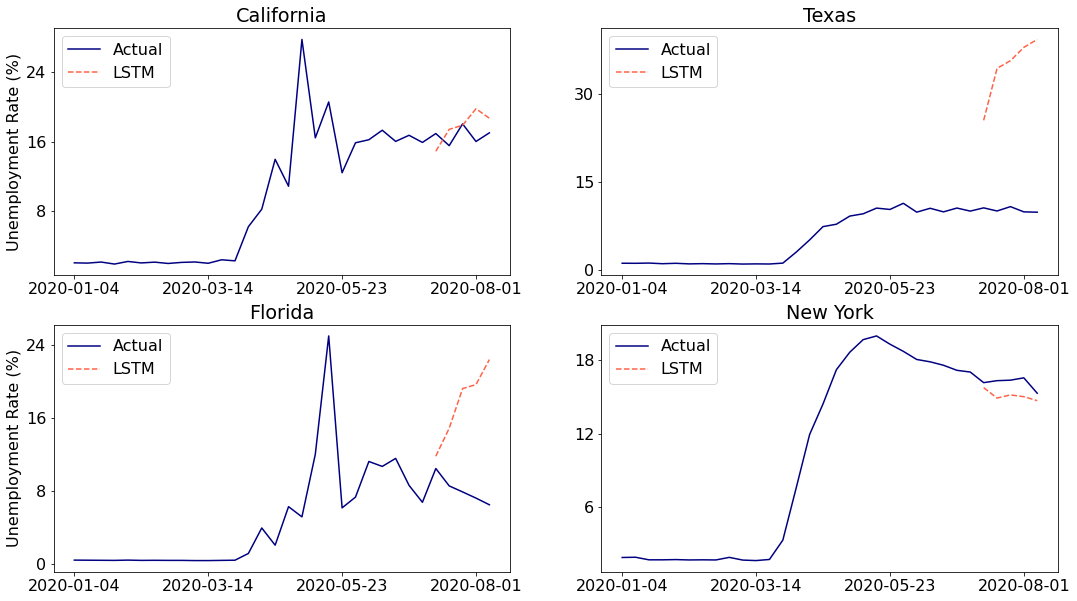

In [ ]:
f,ax = plt.subplots(2, 2,figsize=(18,10))

colNames = ['$\lambda$*','MSE*','RMSE*','MAE*','MSE**','RMSE**','MAE**','State']
modelTable = pd.DataFrame(data=None, columns=colNames)


for i,state in enumerate(states_of_interest):
  #print(f"Printing for model of {state}")
  #print("===================================")
  train_X, train_y, val_X, val_y, test_X, test_y = split_train_val_test(reframed_dfs[i])
  model = load_model(f'/content/drive/My Drive/IDS_2020/SavedModels/{state}_Reg_0_.h5')
  yhat = model.predict(test_X)
  test_X_ = test_X.reshape((test_X.shape[0], test_X.shape[2]))

  # inverse minmax transformation of predictions
  inv_yhat = np.concatenate((yhat, test_X_[:, 1:]), axis=1)
  inv_yhat = scaler.inverse_transform(inv_yhat)
  inv_yhat = inv_yhat[:,0]

  # inverse minmax transformation of test data back to actual
  test_y = test_y.reshape((len(test_y), 1))
  inv_y = np.concatenate((test_y, test_X_[:, 1:]), axis=1)
  inv_y = scaler.inverse_transform(inv_y)
  inv_y = inv_y[:,0]

  # training data error
  yhat_train = model.predict(train_X)
  train_X_ = train_X.reshape((train_X.shape[0], train_X.shape[2]))

  # inverse minmax transformation of training data back to actual
  inv_yhat_train = np.concatenate((yhat_train, train_X_[:, 1:]), axis=1)
  inv_yhat_train = scaler.inverse_transform(inv_yhat_train)
  inv_yhat_train = inv_yhat_train[:,0]

  train_y = train_y.reshape((len(train_y), 1))
  inv_y_train = np.concatenate((train_y, train_X_[:, 1:]), axis=1)
  inv_y_train = scaler.inverse_transform(inv_y_train)
  inv_y_train = inv_y_train[:,0]


  # calculate error metrics
  mse = np.round(mean_squared_error(inv_y, inv_yhat), 2)
  rmse = np.round(sqrt(mean_squared_error(inv_y, inv_yhat)), 2)
  mae = np.round(mean_absolute_error(inv_y, inv_yhat), 2)
  mse_train = np.round(mean_squared_error(inv_y_train, inv_yhat_train), 2)
  rmse_train = np.round(sqrt(mean_squared_error(inv_y_train, inv_yhat_train)), 2)#.round(2)
  mae_train = np.round(mean_absolute_error(inv_y_train, inv_yhat_train), 2)#.round(2)

  state_id = (df['State'] == state)
  actual = df.loc[state_id]['Insured Unemployment Rate']
  #plt.plot(actual, color='blue', label='Actual')  
  #plt.plot(inv_y, color='blue', label='Actual')  
  predicted = np.concatenate(([None for i in range(32-5)],inv_yhat))
  #plt.plot(predicted, color='red', label='LSTM', linestyle='dashed')
  #plt.xlabel('Weeks')  
  #plt.ylabel('Unemployment Rate')
  actual = df.loc[state_id]['Insured Unemployment Rate']
  actual_idx = actual.index.values
  #plt.xticks(actual_idx)
  font = {'weight' : 'normal',
        'size'   : 16}

  plt.rc('font', **font)
  plt.rc('xtick', labelsize=16)     
  plt.rc('ytick', labelsize=16)
  title_name = state
  col1 = 'navy'
  col2 = 'tomato'
  if i == 0:
    ax[0, 0].plot(actual, color=col1)
    ax[0, 0].plot(predicted, color=col2, linestyle='dashed')
    ax[0, 0].set_title(title_name)
    ax[0, 0].set_ylabel('Unemployment Rate (%)')
    ax[0, 0].legend(['Actual', 'LSTM'], loc='upper left')

  elif i == 1:
    ax[0, 1].plot(actual, color=col1)
    ax[0, 1].plot(predicted, color=col2, linestyle='dashed')
    ax[0, 1].set_title(title_name)
    ax[0, 1].legend(['Actual', 'LSTM'], loc='upper left')

  elif i == 2:
    ax[1, 0].plot(actual, color=col1)
    ax[1, 0].plot(predicted, color=col2, linestyle='dashed')
    ax[1, 0].set_title(title_name)
    ax[1, 0].set_ylabel('Unemployment Rate (%)')
    ax[1, 0].legend(['Actual', 'LSTM'], loc='upper left')

  elif i == 3:
    ax[1, 1].plot(actual, color=col1)
    ax[1, 1].plot(predicted, color=col2, linestyle='dashed')
    ax[1, 1].set_title(title_name)
    ax[1, 1].legend(['Actual', 'LSTM'], loc='upper left')
  

  for axi in ax.flat:
      axi.xaxis.set_major_locator(plt.MaxNLocator(4))
      axi.yaxis.set_major_locator(plt.MaxNLocator(4))


  # Table for State errors
  rowToAppend = pd.Series(data=[0,mse_train,rmse_train,mae_train,mse,rmse,mae,state], index=colNames) #, columns=colNames)
  modelTable = modelTable.append(rowToAppend, ignore_index=True).round(2)

plt.savefig('/content/drive/My Drive/IDS_2020/modelPreds.pdf', bbox_inches = 'tight', pad_inches = 0)
#plt.show()
modelTable = modelTable.set_index('State')
modelTable.index.name = ''
modelTable.to_latex('/content/drive/My Drive/IDS_2020/modelTable.tex')
modelTable

# 11.3 LSTM Model for Robustness Check for Michigan & Pennsylvania

$\lambda$*  MSE*  RMSE*  MAE*  MSE**  RMSE**  MAE**
                                                                
Michigan              0  1.37   1.17  0.76   2.05    1.43   1.32
Pennsylvania          0  2.51   1.58  0.89   3.63    1.91   1.45

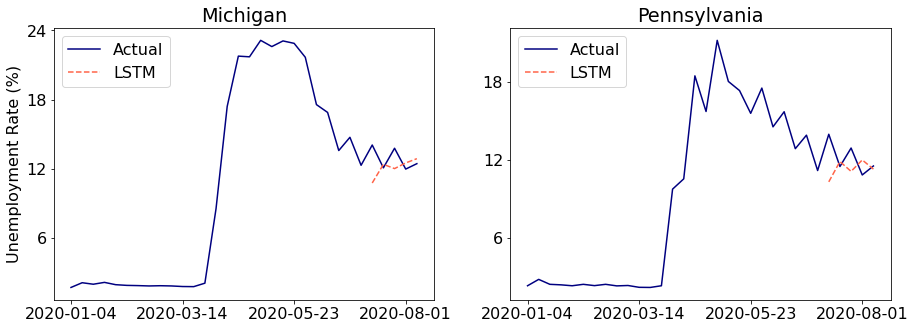

In [ ]:
# Code is exactly same as above, only states_of_interest was changed. Therefore removed and only kept the outputs